In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image
from sklearn.model_selection import GroupShuffleSplit
from collections import Counter
from tqdm.notebook import tqdm
from IPython.display import display
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
SRC_PATH = '/content/drive/MyDrive/work/TNMammo/images'
LBL_PATH = '/content/drive/MyDrive/work/TNMammo/TNMammo_labels.csv'

In [ ]:
def crop_breast_region(img):
    _, binary = cv2.threshold(img, 5, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)

        x, y, w, h = cv2.boundingRect(largest_contour)

        cropped = img[y:y+h, x:x+w]
        return cropped

    return img

def preprocess_image_for_dense_breast(
    image_path,
    output_size=(1024, 1024),
    normalize_min=-1024,
    normalize_max=3071,
    target_mean=0,
    target_std=1
):

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Could not load image {image_path}")

    img = crop_breast_region(img)

    img_float = img.astype(np.float32)
    img_normalized = np.clip(img_float, normalize_min, normalize_max)

    img_normalized = (img_normalized - np.mean(img_normalized)) / (np.std(img_normalized) + 1e-7)

    if target_mean != 0 or target_std != 1:
        img_normalized = img_normalized * target_std + target_mean

    img_uint8 = ((img_normalized - img_normalized.min()) * 255 /
                 (img_normalized.max() - img_normalized.min()))
    img_uint8 = img_uint8.astype(np.uint8)

    img_resized = cv2.resize(img_uint8, output_size, interpolation=cv2.INTER_AREA)

    return img_resized

def process_all_images(data_dir, output_dir, output_size=(1024, 1024), show_samples=True):
    os.makedirs(output_dir, exist_ok=True)

    image_files = []
    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png', '.tiff')):
                image_files.append((root, file))

    for root, file in tqdm(image_files, desc="Processing images"):
        image_path = os.path.join(root, file)

        try:
            if show_samples:
                original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            processed_image = preprocess_image_for_dense_breast(image_path, output_size)

            output_path = os.path.join(output_dir, os.path.relpath(image_path, data_dir))
            os.makedirs(os.path.dirname(output_path), exist_ok=True)
            cv2.imwrite(output_path, processed_image)

            if show_samples:
                plt.figure(figsize=(12, 6))
                plt.subplot(1, 2, 1)
                plt.imshow(original, cmap='gray')
                plt.title('Original Image')
                plt.subplot(1, 2, 2)
                plt.imshow(processed_image, cmap='gray')
                plt.title('Processed Image')
                plt.show()

        except Exception as e:
            print(f"Failed to process {image_path}: {e}")

In [ ]:
from sklearn.model_selection import GroupKFold
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold, StratifiedShuffleSplit

def create_kfold_splits(csv_path, k=5, train_size=0.75, random_state=2003):
    df = pd.read_csv(csv_path)
    print("Distribution of labels:")
    print(df['Labels'].value_counts(normalize=True))

    sgkf = StratifiedGroupKFold(n_splits=k, shuffle=True, random_state=random_state)
    folds = []
    base_path = csv_path.rsplit('.', 1)[0]

    for fold, (train_val_idx, test_idx) in enumerate(
            sgkf.split(X=df,
                       y=df['Labels'],
                       groups=df['ID']),
        start=1):

        train_val_df = df.iloc[train_val_idx].reset_index(drop=True)
        test_df      = df.iloc[test_idx].reset_index(drop=True)


        sss = StratifiedShuffleSplit(n_splits=1,
                                     train_size=train_size,
                                     random_state=random_state)
        tv_labels = train_val_df['Labels']
        tv_indices = np.arange(len(train_val_df))
        train_idx, val_idx = next(sss.split(tv_indices, tv_labels))

        train_df = train_val_df.iloc[train_idx].reset_index(drop=True)
        val_df   = train_val_df.iloc[val_idx].reset_index(drop=True)

        # In thống kê
        print(f"\n——— Fold {fold} ———")
        print(f"Train: patients={train_df['ID'].nunique():d}, images={len(train_df)}")
        print(f"Val:   patients={val_df['ID'].nunique():d}, images={len(val_df)}")
        print(f"Test:  patients={test_df['ID'].nunique():d}, images={len(test_df)}")
        print("  Train label dist:\n", train_df['Labels'].value_counts(normalize=True))
        print("  Val   label dist:\n", val_df['Labels'].value_counts(normalize=True))
        print("  Test  label dist:\n", test_df['Labels'].value_counts(normalize=True))


        train_df.to_csv(f"{base_path}_fold{fold}_train.csv", index=False)
        val_df.to_csv(  f"{base_path}_fold{fold}_val.csv",   index=False)
        test_df.to_csv(f"{base_path}_fold{fold}_test.csv",  index=False)

        folds.append((train_df, val_df, test_df))

    return folds

k = 5
folds = create_kfold_splits(LBL_PATH, k=k, random_state=2003)

Distribution of labels:
Labels
C    0.431953
D    0.341716
B    0.196746
A    0.029586
Name: proportion, dtype: float64

——— Fold 1 ———
Train: patients=405, images=405
Val:   patients=135, images=135
Test:  patients=136, images=136
  Train label dist:
 Labels
C    0.439506
D    0.338272
B    0.190123
A    0.032099
Name: proportion, dtype: float64
  Val   label dist:
 Labels
C    0.437037
D    0.340741
B    0.185185
A    0.037037
Name: proportion, dtype: float64
  Test  label dist:
 Labels
C    0.404412
D    0.352941
B    0.227941
A    0.014706
Name: proportion, dtype: float64

——— Fold 2 ———
Train: patients=405, images=405
Val:   patients=136, images=136
Test:  patients=135, images=135
  Train label dist:
 Labels
C    0.427160
D    0.348148
B    0.192593
A    0.032099
Name: proportion, dtype: float64
  Val   label dist:
 Labels
C    0.426471
D    0.352941
B    0.191176
A    0.029412
Name: proportion, dtype: float64
  Test  label dist:
 Labels
C    0.451852
D    0.311111
B    0.214815
A

In [ ]:
import shutil

def move_images_kfold(main_dir, folds, output_base_dir='split_data'):
    for fold_idx, (train_df, val_df, test_df) in enumerate(folds):

        fold_output_dir = os.path.join(output_base_dir, f'fold_{fold_idx+1}')
        train_out_dir = os.path.join(fold_output_dir, 'train')
        val_out_dir = os.path.join(fold_output_dir, 'val')
        test_out_dir = os.path.join(fold_output_dir, 'test')

        os.makedirs(train_out_dir, exist_ok=True)
        os.makedirs(val_out_dir, exist_ok=True)
        os.makedirs(test_out_dir, exist_ok=True)

        train_ids = set(train_df['ID'].astype(str).str.strip())
        val_ids = set(val_df['ID'].astype(str).str.strip())
        test_ids = set(test_df['ID'].astype(str).str.strip())

        print(f"\nProcessing Fold {fold_idx+1} ... ")
        print("Example folder:", os.listdir(main_dir)[:5])
        print("Example ID in train_df:", list(train_ids)[:5])

        for folder_name in os.listdir(main_dir):
            folder_path = os.path.join(main_dir, folder_name)
            if not os.path.isdir(folder_path):
                continue

            patient_id = folder_name.strip()

            if patient_id in train_ids:
                dest_folder = os.path.join(train_out_dir, folder_name)
            elif patient_id in val_ids:
                dest_folder = os.path.join(val_out_dir, folder_name)
            elif patient_id in test_ids:
                dest_folder = os.path.join(test_out_dir, folder_name)
            else:
                print(f'ID {patient_id} not found in fold {fold_idx+1}')
                continue

            if os.path.exists(dest_folder):
                shutil.rmtree(dest_folder)
            shutil.copytree(folder_path, dest_folder)

PRC_PATH = '/content/drive/MyDrive/work/TNMammo/no_crop'
move_images_kfold(PRC_PATH, folds)


Processing Fold 1 ... 
Example folder: ['20026802', '23086035', '20206015', '24045725', '24100985']
Example ID in train_df: ['18937492', '24056630', '24019213', '22146465', '16002882']

Processing Fold 2 ... 
Example folder: ['20026802', '23086035', '20206015', '24045725', '24100985']
Example ID in train_df: ['24052590', '18937492', '24056630', '24019213', '22146465']

Processing Fold 3 ... 
Example folder: ['20026802', '23086035', '20206015', '24045725', '24100985']
Example ID in train_df: ['24052590', '18936925', '22146465', '16002882', '19170264']

Processing Fold 4 ... 
Example folder: ['20026802', '23086035', '20206015', '24045725', '24100985']
Example ID in train_df: ['24052590', '18936925', '22146465', '16114866', '19018288']

Processing Fold 5 ... 
Example folder: ['20026802', '23086035', '20206015', '24045725', '24100985']
Example ID in train_df: ['24019213', '16114866', '19170264', '24092555', '23271153']


In [ ]:
class BreastCancerDataset(Dataset):
    def __init__(self, data_dir, labels_file, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        self.labels_df = pd.read_csv(labels_file)
        self.label_mapping = self.create_label_mapping(self.labels_df)

        self.patient_folders = [os.path.join(data_dir, folder) for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]

    def __len__(self):
        return len(self.patient_folders)

    def __getitem__(self, idx):
        patient_folder = self.patient_folders[idx]
        patient_name = os.path.basename(patient_folder)
        images = []

        required_views = ['cc', 'mlo']
        required_sides = ['left', 'right']

        for view in required_views:
            for side in required_sides:
                image_path = os.path.join(patient_folder, f'{side}_{view}.jpg')
                if os.path.exists(image_path):
                    image = Image.open(image_path).convert('L')
                    if self.transform:
                        image = self.transform(image)
                    images.append(image)

        if len(images) != 4:
            return None

        images = torch.stack(images)

        label_str = self.label_mapping.get(int(patient_name), None)
        if label_str is None:
            raise ValueError(f"Label for patient '{patient_name}' not found.")

        label_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
        label = label_mapping[label_str]

        return images, label

    def create_label_mapping(self, labels_df):
        label_mapping = {}
        for idx, row in labels_df.iterrows():
            patient_name = row['ID']
            label = row['Labels']
            label_mapping[patient_name] = label
        return label_mapping

def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.ToTensor(),
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fold_datasets = []
for fold_idx in range(len(folds)):
    train_data_dir = f'/content/split_data/fold_{fold_idx+1}/train'
    val_data_dir = f'/content/split_data/fold_{fold_idx+1}/val'
    test_data_dir = f'/content/split_data/fold_{fold_idx+1}/test'
    labels_file = '/content/drive/MyDrive/work/TNMammo/TNMammo_labels.csv'

    # create datatset
    train_dataset = BreastCancerDataset(train_data_dir, labels_file, transform=transform)
    val_dataset = BreastCancerDataset(val_data_dir, labels_file, transform=transform_test)
    test_dataset = BreastCancerDataset(test_data_dir, labels_file, transform=transform_test)

    # Cal class weights
    label_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
    counter = Counter()
    for folder in train_dataset.patient_folders:
        patient_name = os.path.basename(folder)
        label_str = train_dataset.label_mapping[int(patient_name)]
        label = label_mapping[label_str]
        counter[label] += 1

    counts = [counter[i] for i in range(len(label_mapping))]
    total_samples = sum(counts)
    num_classes = len(counts)
    class_weights = [total_samples / (num_classes * c) for c in counts]
    class_weights = torch.tensor(class_weights, dtype=torch.float, device=device)

    # sampler weights
    sample_weights = []
    for folder in train_dataset.patient_folders:
        patient_name = int(os.path.basename(folder))
        label_str = train_dataset.label_mapping[patient_name]
        label = label_mapping[label_str]
        sample_weights.append(class_weights[label].item())

    sample_weights = torch.DoubleTensor(sample_weights)

    # create sampler
    sampler = torch.utils.data.WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

    # data loader
    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

    fold_datasets.append((train_loader, val_loader, test_loader, class_weights))

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

class ResNetFeatureExtractor(nn.Module):
    def __init__(self, num_classes=4):
        super(ResNetFeatureExtractor, self).__init__()

        self.resnet1 = models.resnet50(pretrained=False)
        self.resnet2 = models.resnet50(pretrained=False)
        self.resnet3 = models.resnet50(pretrained=False)
        self.resnet4 = models.resnet50(pretrained=False)

        lvm_med_weights = torch.load('/content/drive/MyDrive/work/TNMammo/weights/lvmmed_resnet.torch', map_location=device)

        for resnet in [self.resnet1, self.resnet2, self.resnet3, self.resnet4]:
            resnet.load_state_dict(lvm_med_weights, strict=False)
            resnet.fc = Identity()

        self.fc_combined = nn.Linear(4 * 2048, 1024)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc_out = nn.Linear(1024, num_classes)  #

    def forward(self, x):
        features = []

        img = x[:, 0, :, :, :]
        out = self.resnet1(img)
        features.append(out)

        img = x[:, 1, :, :, :]
        out = self.resnet2(img)
        features.append(out)

        img = x[:, 2, :, :, :]
        out = self.resnet3(img)
        features.append(out)

        img = x[:, 3, :, :, :]
        out = self.resnet4(img)
        features.append(out)

        combined_features = torch.cat(features, dim=1)
        combined_features = self.fc_combined(combined_features)
        combined_features = self.relu(combined_features)
        combined_features = self.dropout(combined_features)
        output = self.fc_out(combined_features)

        return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetFeatureExtractor(num_classes=4)
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNetFeatureExtractor(
  (resnet1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequent

In [ ]:
# Accuracy function
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, dim=1)

    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)

In [ ]:
from collections import defaultdict

def calculate_accuracy_per_class(outputs, labels, num_classes=4):
    _, predicted = torch.max(outputs, 1)
    correct_per_class = defaultdict(int)
    total_per_class = defaultdict(int)

    for i in range(num_classes):
        correct_per_class[i] = ((predicted == i) & (labels == i)).sum().item()
        total_per_class[i] = (labels == i).sum().item()

    return correct_per_class, total_per_class

In [ ]:
def calculate_f1_score(outputs, labels):
    _, predicted = torch.max(outputs, 1)

    tp = (predicted & labels).sum().to(torch.float32)
    fp = (predicted & (1 - labels)).sum().to(torch.float32)
    fn = ((1 - predicted) & labels).sum().to(torch.float32)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return f1, precision, recall

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

def evaluate_model(model, data_loader, criterion, num_classes=4):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(data_loader)
    accuracy = 100 * (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels)
    f1 = 100 * f1_score(all_labels, all_preds, average='weighted')
    precision = 100 * precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = 100 * recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    correct_per_class = {i: 0 for i in range(num_classes)}
    total_per_class = {i: 0 for i in range(num_classes)}
    for pred, label in zip(all_preds, all_labels):
        if pred == label:
            correct_per_class[label] += 1
        total_per_class[label] += 1

    accuracy_per_class = {cls: 100 * correct_per_class[cls] / total_per_class[cls] if total_per_class[cls] > 0 else 0 for cls in range(num_classes)}

    model.train()
    return avg_loss, accuracy, f1, precision, recall, accuracy_per_class

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 100
k = 5
fold_results = []

for fold_idx, (train_loader, val_loader, test_loader, class_weights) in enumerate(fold_datasets):
    print(f"\Training Fold {fold_idx+1}/{k}")
    print("------")
    # Define model
    model = ResNetFeatureExtractor(num_classes=4).to(device)

    # Define criterion, optimizer, scheduler
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.SGD(model.parameters(), lr=5e-3, momentum=0.9, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

    # Save
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    val_f1_scores = []
    val_precisions = []
    val_recalls = []
    best_val_accuracy = 0.0

    # training
    for epoch in range(EPOCHS):
        print("Training...")
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(train_loader, desc=f"Fold {fold_idx+1} Epoch {epoch+1}/{EPOCHS}", leave=False)
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += calculate_accuracy(outputs, labels) * labels.size(0)
            total += labels.size(0)

            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # evaluate
        val_loss, val_accuracy, val_f1_score, val_precision, val_recall, val_accuracy_per_class = evaluate_model(model, val_loader, criterion)

        # update scheduler
        scheduler.step(val_loss)

        # save best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best-model-fold{fold_idx+1}.pt')
            print(f"Fold {fold_idx+1}: Best model saved !!! Accuracy: {best_val_accuracy:.2f}%")


        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1_score)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)

        print(f'Fold {fold_idx+1}, Epoch [{epoch+1}/{EPOCHS}]')
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, '
              f'F1 Score: {val_f1_score:.4f}%, Precision: {val_precision:.4f}%, Recall: {val_recall:.4f}%')

        print("=========================================================================================")

    # Test set
    test_loss, test_accuracy, test_f1_score, test_precision, test_recall, test_accuracy_per_class = evaluate_model(model, test_loader, criterion)
    print(f'Fold {fold_idx+1} Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    # Save fold
    fold_results.append({
        'fold': fold_idx + 1,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'val_f1_scores': val_f1_scores,
        'val_precisions': val_precisions,
        'val_recalls': val_recalls,
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'test_f1_score': test_f1_score,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_accuracy_per_class': test_accuracy_per_class
    })

# Report
avg_test_accuracy = np.mean([result['test_accuracy'] for result in fold_results])
std_test_accuracy = np.std([result['test_accuracy'] for result in fold_results])
avg_test_f1 = np.mean([result['test_f1_score'] for result in fold_results])
std_test_f1 = np.std([result['test_f1_score'] for result in fold_results])
avg_test_precision = np.mean([result['test_precision'] for result in fold_results])
std_test_precision = np.std([result['test_precision'] for result in fold_results])
avg_test_recall = np.mean([result['test_recall'] for result in fold_results])
std_test_recall = np.std([result['test_recall'] for result in fold_results])

print(f"\nResult K-Fold Cross-Validation:")
print(f"Accuracy Avg on Test: {avg_test_accuracy:.2f}% ± {std_test_accuracy:.2f}%")
print(f"F1 Score Avg on Test: {avg_test_f1:.2f}% ± {std_test_f1:.2f}%")
print(f"Precision Avg on Test: {avg_test_precision:.2f}% ± {std_test_precision:.2f}%")
print(f"Recall Avg on Test: {avg_test_recall:.2f}% ± {std_test_recall:.2f}%")

\Training Fold 1/5
------
Training...


Fold 1 Epoch 1/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1: Best model saved !!! Accuracy: 3.70%
Fold 1, Epoch [1/100]
Train Loss: 1.0267, Train Accuracy: 26.91%
Validation Loss: 1.7069, Validation Accuracy: 3.70%, F1 Score: 0.2646%, Precision: 0.1372%, Recall: 3.7037%
Training...


Fold 1 Epoch 2/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [2/100]
Train Loss: 0.7406, Train Accuracy: 25.19%
Validation Loss: 1.6229, Validation Accuracy: 3.70%, F1 Score: 0.2646%, Precision: 0.1372%, Recall: 3.7037%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 3/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [3/100]
Train Loss: 0.5509, Train Accuracy: 22.72%
Validation Loss: 1.4594, Validation Accuracy: 3.70%, F1 Score: 0.2646%, Precision: 0.1372%, Recall: 3.7037%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 4/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1: Best model saved !!! Accuracy: 13.33%
Fold 1, Epoch [4/100]
Train Loss: 0.3787, Train Accuracy: 33.58%
Validation Loss: 1.1659, Validation Accuracy: 13.33%, F1 Score: 4.7612%, Precision: 2.9122%, Recall: 13.3333%
Training...


Fold 1 Epoch 5/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1: Best model saved !!! Accuracy: 19.26%
Fold 1, Epoch [5/100]
Train Loss: 0.3310, Train Accuracy: 47.16%
Validation Loss: 1.1776, Validation Accuracy: 19.26%, F1 Score: 7.7180%, Precision: 5.4986%, Recall: 19.2593%
Training...


Fold 1 Epoch 6/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [6/100]
Train Loss: 0.2865, Train Accuracy: 49.38%
Validation Loss: 1.2647, Validation Accuracy: 19.26%, F1 Score: 7.0580%, Precision: 7.1587%, Recall: 19.2593%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 7/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [7/100]
Train Loss: 0.2739, Train Accuracy: 50.62%
Validation Loss: 1.2242, Validation Accuracy: 18.52%, F1 Score: 6.6841%, Precision: 5.1935%, Recall: 18.5185%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 8/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [8/100]
Train Loss: 0.2270, Train Accuracy: 51.11%
Validation Loss: 1.3289, Validation Accuracy: 18.52%, F1 Score: 5.7870%, Precision: 3.4294%, Recall: 18.5185%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 9/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1: Best model saved !!! Accuracy: 28.89%
Fold 1, Epoch [9/100]
Train Loss: 0.1916, Train Accuracy: 60.49%
Validation Loss: 1.3225, Validation Accuracy: 28.89%, F1 Score: 20.9012%, Precision: 26.7771%, Recall: 28.8889%
Training...


Fold 1 Epoch 10/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1: Best model saved !!! Accuracy: 37.04%
Fold 1, Epoch [10/100]
Train Loss: 0.2030, Train Accuracy: 66.42%
Validation Loss: 1.4039, Validation Accuracy: 37.04%, F1 Score: 27.4724%, Precision: 24.7857%, Recall: 37.0370%
Training...


Fold 1 Epoch 11/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1: Best model saved !!! Accuracy: 42.22%
Fold 1, Epoch [11/100]
Train Loss: 0.1611, Train Accuracy: 71.36%
Validation Loss: 1.2800, Validation Accuracy: 42.22%, F1 Score: 30.1464%, Precision: 24.5204%, Recall: 42.2222%
Training...


Fold 1 Epoch 12/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1: Best model saved !!! Accuracy: 50.37%
Fold 1, Epoch [12/100]
Train Loss: 0.1631, Train Accuracy: 76.05%
Validation Loss: 1.1406, Validation Accuracy: 50.37%, F1 Score: 37.8913%, Precision: 73.7970%, Recall: 50.3704%
Training...


Fold 1 Epoch 13/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [13/100]
Train Loss: 0.1290, Train Accuracy: 78.27%
Validation Loss: 1.3865, Validation Accuracy: 48.89%, F1 Score: 35.4707%, Precision: 49.3457%, Recall: 48.8889%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 14/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1: Best model saved !!! Accuracy: 59.26%
Fold 1, Epoch [14/100]
Train Loss: 0.1262, Train Accuracy: 79.26%
Validation Loss: 1.1696, Validation Accuracy: 59.26%, F1 Score: 56.8051%, Precision: 62.5281%, Recall: 59.2593%
Training...


Fold 1 Epoch 15/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1: Best model saved !!! Accuracy: 60.00%
Fold 1, Epoch [15/100]
Train Loss: 0.1044, Train Accuracy: 85.19%
Validation Loss: 1.3867, Validation Accuracy: 60.00%, F1 Score: 58.8648%, Precision: 57.8647%, Recall: 60.0000%
Training...


Fold 1 Epoch 16/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1: Best model saved !!! Accuracy: 64.44%
Fold 1, Epoch [16/100]
Train Loss: 0.0899, Train Accuracy: 91.11%
Validation Loss: 1.3789, Validation Accuracy: 64.44%, F1 Score: 63.0016%, Precision: 62.5131%, Recall: 64.4444%
Training...


Fold 1 Epoch 17/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [17/100]
Train Loss: 0.0811, Train Accuracy: 89.38%
Validation Loss: 1.2172, Validation Accuracy: 62.96%, F1 Score: 62.5228%, Precision: 64.7984%, Recall: 62.9630%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 18/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1: Best model saved !!! Accuracy: 67.41%
Fold 1, Epoch [18/100]
Train Loss: 0.0711, Train Accuracy: 89.63%
Validation Loss: 1.1964, Validation Accuracy: 67.41%, F1 Score: 67.3036%, Precision: 68.2260%, Recall: 67.4074%
Training...


Fold 1 Epoch 19/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [19/100]
Train Loss: 0.0784, Train Accuracy: 90.62%
Validation Loss: 1.2567, Validation Accuracy: 60.74%, F1 Score: 60.4898%, Precision: 61.5948%, Recall: 60.7407%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 20/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [20/100]
Train Loss: 0.0702, Train Accuracy: 90.86%
Validation Loss: 1.2985, Validation Accuracy: 59.26%, F1 Score: 58.9018%, Precision: 60.2650%, Recall: 59.2593%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 21/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [21/100]
Train Loss: 0.0629, Train Accuracy: 90.37%
Validation Loss: 1.0231, Validation Accuracy: 57.78%, F1 Score: 57.1452%, Precision: 60.6043%, Recall: 57.7778%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 22/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [22/100]
Train Loss: 0.0557, Train Accuracy: 95.06%
Validation Loss: 1.2149, Validation Accuracy: 58.52%, F1 Score: 57.7192%, Precision: 59.8682%, Recall: 58.5185%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 23/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [23/100]
Train Loss: 0.0442, Train Accuracy: 94.07%
Validation Loss: 1.4780, Validation Accuracy: 65.93%, F1 Score: 65.7463%, Precision: 66.9382%, Recall: 65.9259%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 24/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [24/100]
Train Loss: 0.0595, Train Accuracy: 92.59%
Validation Loss: 1.3320, Validation Accuracy: 60.74%, F1 Score: 60.3356%, Precision: 62.0848%, Recall: 60.7407%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 25/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [25/100]
Train Loss: 0.0339, Train Accuracy: 96.30%
Validation Loss: 1.2460, Validation Accuracy: 60.74%, F1 Score: 60.4589%, Precision: 62.6792%, Recall: 60.7407%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 26/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [26/100]
Train Loss: 0.0336, Train Accuracy: 96.30%
Validation Loss: 1.3664, Validation Accuracy: 62.96%, F1 Score: 62.4361%, Precision: 64.7924%, Recall: 62.9630%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 27/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [27/100]
Train Loss: 0.0277, Train Accuracy: 96.79%
Validation Loss: 1.2530, Validation Accuracy: 67.41%, F1 Score: 66.7270%, Precision: 68.3433%, Recall: 67.4074%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 28/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [28/100]
Train Loss: 0.0288, Train Accuracy: 98.52%
Validation Loss: 1.2323, Validation Accuracy: 62.22%, F1 Score: 61.3811%, Precision: 64.3325%, Recall: 62.2222%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 29/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [29/100]
Train Loss: 0.0321, Train Accuracy: 97.53%
Validation Loss: 1.5971, Validation Accuracy: 60.74%, F1 Score: 60.1313%, Precision: 62.8971%, Recall: 60.7407%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 30/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [30/100]
Train Loss: 0.0144, Train Accuracy: 99.01%
Validation Loss: 1.7583, Validation Accuracy: 62.96%, F1 Score: 61.5232%, Precision: 61.6706%, Recall: 62.9630%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 31/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [31/100]
Train Loss: 0.0170, Train Accuracy: 99.01%
Validation Loss: 1.6857, Validation Accuracy: 62.22%, F1 Score: 60.7217%, Precision: 61.0638%, Recall: 62.2222%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 32/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [32/100]
Train Loss: 0.0216, Train Accuracy: 99.01%
Validation Loss: 1.3385, Validation Accuracy: 64.44%, F1 Score: 63.7012%, Precision: 66.3846%, Recall: 64.4444%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 33/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [33/100]
Train Loss: 0.0197, Train Accuracy: 98.27%
Validation Loss: 1.5871, Validation Accuracy: 64.44%, F1 Score: 63.6367%, Precision: 66.8153%, Recall: 64.4444%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 34/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [34/100]
Train Loss: 0.0112, Train Accuracy: 100.00%
Validation Loss: 1.5909, Validation Accuracy: 63.70%, F1 Score: 62.8738%, Precision: 66.1660%, Recall: 63.7037%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 35/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [35/100]
Train Loss: 0.0172, Train Accuracy: 98.52%
Validation Loss: 1.4495, Validation Accuracy: 62.96%, F1 Score: 61.6949%, Precision: 65.8577%, Recall: 62.9630%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 36/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [36/100]
Train Loss: 0.0133, Train Accuracy: 98.77%
Validation Loss: 1.6075, Validation Accuracy: 60.74%, F1 Score: 58.7725%, Precision: 64.3711%, Recall: 60.7407%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 37/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [37/100]
Train Loss: 0.0245, Train Accuracy: 97.53%
Validation Loss: 1.6589, Validation Accuracy: 62.22%, F1 Score: 60.2496%, Precision: 60.2239%, Recall: 62.2222%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 38/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [38/100]
Train Loss: 0.0136, Train Accuracy: 99.75%
Validation Loss: 1.4377, Validation Accuracy: 62.96%, F1 Score: 59.7997%, Precision: 71.5125%, Recall: 62.9630%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 39/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [39/100]
Train Loss: 0.0107, Train Accuracy: 99.75%
Validation Loss: 1.5003, Validation Accuracy: 63.70%, F1 Score: 62.7762%, Precision: 65.8843%, Recall: 63.7037%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 40/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [40/100]
Train Loss: 0.0064, Train Accuracy: 99.51%
Validation Loss: 1.4832, Validation Accuracy: 63.70%, F1 Score: 62.3597%, Precision: 66.2946%, Recall: 63.7037%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 41/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1: Best model saved !!! Accuracy: 68.15%
Fold 1, Epoch [41/100]
Train Loss: 0.0103, Train Accuracy: 99.26%
Validation Loss: 1.6637, Validation Accuracy: 68.15%, F1 Score: 66.9989%, Precision: 70.2975%, Recall: 68.1481%
Training...


Fold 1 Epoch 42/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [42/100]
Train Loss: 0.0067, Train Accuracy: 99.51%
Validation Loss: 1.6628, Validation Accuracy: 66.67%, F1 Score: 65.3426%, Precision: 69.4083%, Recall: 66.6667%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 43/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [43/100]
Train Loss: 0.0062, Train Accuracy: 99.75%
Validation Loss: 1.7645, Validation Accuracy: 65.19%, F1 Score: 63.0519%, Precision: 62.9037%, Recall: 65.1852%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 44/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [44/100]
Train Loss: 0.0076, Train Accuracy: 99.75%
Validation Loss: 1.5460, Validation Accuracy: 63.70%, F1 Score: 62.3624%, Precision: 65.7211%, Recall: 63.7037%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 45/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [45/100]
Train Loss: 0.0080, Train Accuracy: 99.51%
Validation Loss: 1.8610, Validation Accuracy: 63.70%, F1 Score: 61.8218%, Precision: 62.9817%, Recall: 63.7037%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 46/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [46/100]
Train Loss: 0.0072, Train Accuracy: 99.75%
Validation Loss: 1.7505, Validation Accuracy: 65.19%, F1 Score: 64.4637%, Precision: 67.1821%, Recall: 65.1852%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 47/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [47/100]
Train Loss: 0.0047, Train Accuracy: 99.51%
Validation Loss: 1.8636, Validation Accuracy: 63.70%, F1 Score: 62.3173%, Precision: 65.5195%, Recall: 63.7037%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 48/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [48/100]
Train Loss: 0.0035, Train Accuracy: 100.00%
Validation Loss: 2.2665, Validation Accuracy: 67.41%, F1 Score: 65.7823%, Precision: 65.5630%, Recall: 67.4074%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 49/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [49/100]
Train Loss: 0.0043, Train Accuracy: 100.00%
Validation Loss: 1.9666, Validation Accuracy: 67.41%, F1 Score: 65.8514%, Precision: 65.9024%, Recall: 67.4074%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 50/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [50/100]
Train Loss: 0.0038, Train Accuracy: 100.00%
Validation Loss: 1.7263, Validation Accuracy: 62.22%, F1 Score: 60.7015%, Precision: 64.1608%, Recall: 62.2222%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 51/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [51/100]
Train Loss: 0.0045, Train Accuracy: 99.26%
Validation Loss: 2.1428, Validation Accuracy: 64.44%, F1 Score: 62.7572%, Precision: 62.7014%, Recall: 64.4444%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 52/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [52/100]
Train Loss: 0.0032, Train Accuracy: 100.00%
Validation Loss: 2.3420, Validation Accuracy: 63.70%, F1 Score: 62.1550%, Precision: 62.1266%, Recall: 63.7037%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 53/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [53/100]
Train Loss: 0.0030, Train Accuracy: 99.75%
Validation Loss: 2.4909, Validation Accuracy: 61.48%, F1 Score: 59.4059%, Precision: 60.3045%, Recall: 61.4815%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 54/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [54/100]
Train Loss: 0.0077, Train Accuracy: 99.26%
Validation Loss: 2.1078, Validation Accuracy: 68.15%, F1 Score: 66.6675%, Precision: 66.7023%, Recall: 68.1481%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 55/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [55/100]
Train Loss: 0.0056, Train Accuracy: 99.51%
Validation Loss: 1.6958, Validation Accuracy: 65.93%, F1 Score: 63.9659%, Precision: 66.1393%, Recall: 65.9259%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 56/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [56/100]
Train Loss: 0.0074, Train Accuracy: 99.51%
Validation Loss: 2.5098, Validation Accuracy: 62.96%, F1 Score: 60.9105%, Precision: 60.9534%, Recall: 62.9630%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 57/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [57/100]
Train Loss: 0.0051, Train Accuracy: 99.75%
Validation Loss: 2.5061, Validation Accuracy: 60.74%, F1 Score: 58.1660%, Precision: 60.3494%, Recall: 60.7407%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 58/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [58/100]
Train Loss: 0.0026, Train Accuracy: 100.00%
Validation Loss: 2.1217, Validation Accuracy: 62.96%, F1 Score: 60.5344%, Precision: 62.3238%, Recall: 62.9630%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 59/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [59/100]
Train Loss: 0.0018, Train Accuracy: 100.00%
Validation Loss: 1.9153, Validation Accuracy: 61.48%, F1 Score: 59.5621%, Precision: 60.5520%, Recall: 61.4815%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 60/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [60/100]
Train Loss: 0.0018, Train Accuracy: 100.00%
Validation Loss: 1.9595, Validation Accuracy: 65.19%, F1 Score: 64.2174%, Precision: 67.0708%, Recall: 65.1852%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 61/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [61/100]
Train Loss: 0.0022, Train Accuracy: 100.00%
Validation Loss: 1.8902, Validation Accuracy: 65.19%, F1 Score: 63.4460%, Precision: 68.5516%, Recall: 65.1852%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 62/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [62/100]
Train Loss: 0.0016, Train Accuracy: 100.00%
Validation Loss: 1.8304, Validation Accuracy: 65.93%, F1 Score: 64.4172%, Precision: 68.0607%, Recall: 65.9259%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 63/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [63/100]
Train Loss: 0.0014, Train Accuracy: 100.00%
Validation Loss: 1.8556, Validation Accuracy: 64.44%, F1 Score: 61.6061%, Precision: 63.6426%, Recall: 64.4444%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 64/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [64/100]
Train Loss: 0.0028, Train Accuracy: 99.51%
Validation Loss: 2.4190, Validation Accuracy: 63.70%, F1 Score: 61.2649%, Precision: 62.2268%, Recall: 63.7037%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 65/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [65/100]
Train Loss: 0.0015, Train Accuracy: 100.00%
Validation Loss: 2.2747, Validation Accuracy: 64.44%, F1 Score: 62.1765%, Precision: 62.8863%, Recall: 64.4444%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 66/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [66/100]
Train Loss: 0.0011, Train Accuracy: 100.00%
Validation Loss: 2.1018, Validation Accuracy: 64.44%, F1 Score: 62.1765%, Precision: 62.8863%, Recall: 64.4444%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 67/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [67/100]
Train Loss: 0.0028, Train Accuracy: 99.75%
Validation Loss: 2.3191, Validation Accuracy: 65.19%, F1 Score: 63.0187%, Precision: 64.0085%, Recall: 65.1852%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 68/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [68/100]
Train Loss: 0.0015, Train Accuracy: 100.00%
Validation Loss: 1.9668, Validation Accuracy: 64.44%, F1 Score: 62.1765%, Precision: 62.8863%, Recall: 64.4444%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 69/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [69/100]
Train Loss: 0.0014, Train Accuracy: 100.00%
Validation Loss: 1.9123, Validation Accuracy: 63.70%, F1 Score: 61.1531%, Precision: 62.2153%, Recall: 63.7037%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 70/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [70/100]
Train Loss: 0.0031, Train Accuracy: 99.51%
Validation Loss: 1.9950, Validation Accuracy: 65.19%, F1 Score: 62.9186%, Precision: 63.4352%, Recall: 65.1852%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 71/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [71/100]
Train Loss: 0.0025, Train Accuracy: 99.75%
Validation Loss: 2.4028, Validation Accuracy: 65.93%, F1 Score: 63.5401%, Precision: 65.0247%, Recall: 65.9259%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 72/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [72/100]
Train Loss: 0.0034, Train Accuracy: 99.75%
Validation Loss: 2.4944, Validation Accuracy: 62.22%, F1 Score: 60.3034%, Precision: 62.8002%, Recall: 62.2222%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 73/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [73/100]
Train Loss: 0.0007, Train Accuracy: 100.00%
Validation Loss: 2.1933, Validation Accuracy: 65.19%, F1 Score: 62.6734%, Precision: 62.5323%, Recall: 65.1852%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 74/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [74/100]
Train Loss: 0.0038, Train Accuracy: 99.26%
Validation Loss: 2.6289, Validation Accuracy: 62.96%, F1 Score: 60.2875%, Precision: 60.2875%, Recall: 62.9630%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 75/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [75/100]
Train Loss: 0.0017, Train Accuracy: 100.00%
Validation Loss: 2.1079, Validation Accuracy: 64.44%, F1 Score: 62.9148%, Precision: 62.2870%, Recall: 64.4444%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 76/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [76/100]
Train Loss: 0.0016, Train Accuracy: 100.00%
Validation Loss: 2.0007, Validation Accuracy: 65.19%, F1 Score: 63.8487%, Precision: 63.2071%, Recall: 65.1852%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 77/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [77/100]
Train Loss: 0.0029, Train Accuracy: 99.75%
Validation Loss: 1.6306, Validation Accuracy: 64.44%, F1 Score: 63.4959%, Precision: 66.4300%, Recall: 64.4444%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 78/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1: Best model saved !!! Accuracy: 69.63%
Fold 1, Epoch [78/100]
Train Loss: 0.0018, Train Accuracy: 99.75%
Validation Loss: 1.7802, Validation Accuracy: 69.63%, F1 Score: 68.4079%, Precision: 70.6050%, Recall: 69.6296%
Training...


Fold 1 Epoch 79/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [79/100]
Train Loss: 0.0008, Train Accuracy: 100.00%
Validation Loss: 1.9185, Validation Accuracy: 63.70%, F1 Score: 61.7828%, Precision: 62.2787%, Recall: 63.7037%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 80/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [80/100]
Train Loss: 0.0009, Train Accuracy: 100.00%
Validation Loss: 1.8639, Validation Accuracy: 66.67%, F1 Score: 65.0430%, Precision: 65.2516%, Recall: 66.6667%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 81/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [81/100]
Train Loss: 0.0028, Train Accuracy: 99.75%
Validation Loss: 1.7264, Validation Accuracy: 66.67%, F1 Score: 65.5436%, Precision: 69.1108%, Recall: 66.6667%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 82/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [82/100]
Train Loss: 0.0012, Train Accuracy: 99.75%
Validation Loss: 2.0339, Validation Accuracy: 64.44%, F1 Score: 62.1732%, Precision: 63.3575%, Recall: 64.4444%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 83/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [83/100]
Train Loss: 0.0007, Train Accuracy: 100.00%
Validation Loss: 2.2708, Validation Accuracy: 65.19%, F1 Score: 62.9122%, Precision: 63.8984%, Recall: 65.1852%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 84/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [84/100]
Train Loss: 0.0025, Train Accuracy: 99.75%
Validation Loss: 2.2726, Validation Accuracy: 64.44%, F1 Score: 62.1732%, Precision: 63.3575%, Recall: 64.4444%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 85/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [85/100]
Train Loss: 0.0020, Train Accuracy: 99.75%
Validation Loss: 2.3670, Validation Accuracy: 64.44%, F1 Score: 62.2302%, Precision: 63.0592%, Recall: 64.4444%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 86/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [86/100]
Train Loss: 0.0047, Train Accuracy: 99.75%
Validation Loss: 2.5587, Validation Accuracy: 56.30%, F1 Score: 52.8174%, Precision: 53.9415%, Recall: 56.2963%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 87/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [87/100]
Train Loss: 0.0040, Train Accuracy: 99.51%
Validation Loss: 2.0417, Validation Accuracy: 59.26%, F1 Score: 56.9741%, Precision: 59.3878%, Recall: 59.2593%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 88/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [88/100]
Train Loss: 0.0023, Train Accuracy: 99.51%
Validation Loss: 2.3527, Validation Accuracy: 60.74%, F1 Score: 58.5447%, Precision: 60.2574%, Recall: 60.7407%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 89/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [89/100]
Train Loss: 0.0047, Train Accuracy: 99.51%
Validation Loss: 2.0010, Validation Accuracy: 63.70%, F1 Score: 62.0592%, Precision: 62.2281%, Recall: 63.7037%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 90/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [90/100]
Train Loss: 0.0027, Train Accuracy: 99.75%
Validation Loss: 2.1154, Validation Accuracy: 65.93%, F1 Score: 65.0609%, Precision: 66.7815%, Recall: 65.9259%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 91/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [91/100]
Train Loss: 0.0038, Train Accuracy: 99.51%
Validation Loss: 2.5727, Validation Accuracy: 66.67%, F1 Score: 65.6505%, Precision: 68.0701%, Recall: 66.6667%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 92/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [92/100]
Train Loss: 0.0019, Train Accuracy: 99.75%
Validation Loss: 2.3372, Validation Accuracy: 63.70%, F1 Score: 61.6225%, Precision: 62.9942%, Recall: 63.7037%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 93/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [93/100]
Train Loss: 0.0025, Train Accuracy: 99.75%
Validation Loss: 2.2057, Validation Accuracy: 62.96%, F1 Score: 60.8636%, Precision: 61.7159%, Recall: 62.9630%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 94/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [94/100]
Train Loss: 0.0018, Train Accuracy: 100.00%
Validation Loss: 2.1970, Validation Accuracy: 62.96%, F1 Score: 60.5989%, Precision: 60.9216%, Recall: 62.9630%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 95/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [95/100]
Train Loss: 0.0018, Train Accuracy: 99.75%
Validation Loss: 2.6348, Validation Accuracy: 62.96%, F1 Score: 61.1026%, Precision: 61.9330%, Recall: 62.9630%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 96/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [96/100]
Train Loss: 0.0019, Train Accuracy: 99.75%
Validation Loss: 2.1545, Validation Accuracy: 62.96%, F1 Score: 61.6058%, Precision: 64.0999%, Recall: 62.9630%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 97/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [97/100]
Train Loss: 0.0015, Train Accuracy: 100.00%
Validation Loss: 2.0808, Validation Accuracy: 63.70%, F1 Score: 61.3207%, Precision: 62.3501%, Recall: 63.7037%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 98/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [98/100]
Train Loss: 0.0026, Train Accuracy: 99.75%
Validation Loss: 2.1065, Validation Accuracy: 60.74%, F1 Score: 58.1660%, Precision: 60.3494%, Recall: 60.7407%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 99/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 1, Epoch [99/100]
Train Loss: 0.0011, Train Accuracy: 100.00%
Validation Loss: 2.6994, Validation Accuracy: 58.52%, F1 Score: 55.4056%, Precision: 59.0831%, Recall: 58.5185%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1 Epoch 100/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 1, Epoch [100/100]
Train Loss: 0.0012, Train Accuracy: 100.00%
Validation Loss: 2.5082, Validation Accuracy: 58.52%, F1 Score: 55.6946%, Precision: 59.2017%, Recall: 58.5185%
Fold 1 Test Loss: 1.9474, Test Accuracy: 66.91%
\Training Fold 2/5
------


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training...


Fold 2 Epoch 1/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2: Best model saved !!! Accuracy: 2.94%
Fold 2, Epoch [1/100]
Train Loss: 0.9874, Train Accuracy: 27.41%
Validation Loss: 2.0673, Validation Accuracy: 2.94%, F1 Score: 0.1681%, Precision: 0.0865%, Recall: 2.9412%
Training...


Fold 2 Epoch 2/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [2/100]
Train Loss: 0.6628, Train Accuracy: 24.20%
Validation Loss: 1.7607, Validation Accuracy: 2.94%, F1 Score: 0.1681%, Precision: 0.0865%, Recall: 2.9412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 3/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [3/100]
Train Loss: 0.4300, Train Accuracy: 27.16%
Validation Loss: 1.5440, Validation Accuracy: 2.94%, F1 Score: 0.1681%, Precision: 0.0865%, Recall: 2.9412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 4/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2: Best model saved !!! Accuracy: 20.59%
Fold 2, Epoch [4/100]
Train Loss: 0.3904, Train Accuracy: 43.46%
Validation Loss: 1.2844, Validation Accuracy: 20.59%, F1 Score: 7.6776%, Precision: 4.8369%, Recall: 20.5882%
Training...


Fold 2 Epoch 5/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [5/100]
Train Loss: 0.3202, Train Accuracy: 50.86%
Validation Loss: 1.2336, Validation Accuracy: 20.59%, F1 Score: 7.8922%, Precision: 5.1471%, Recall: 20.5882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 6/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [6/100]
Train Loss: 0.2770, Train Accuracy: 54.81%
Validation Loss: 1.2238, Validation Accuracy: 19.85%, F1 Score: 7.5205%, Precision: 5.0914%, Recall: 19.8529%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 7/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2: Best model saved !!! Accuracy: 21.32%
Fold 2, Epoch [7/100]
Train Loss: 0.2348, Train Accuracy: 51.60%
Validation Loss: 1.3664, Validation Accuracy: 21.32%, F1 Score: 10.3643%, Precision: 30.2362%, Recall: 21.3235%
Training...


Fold 2 Epoch 8/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2: Best model saved !!! Accuracy: 43.38%
Fold 2, Epoch [8/100]
Train Loss: 0.2127, Train Accuracy: 61.48%
Validation Loss: 1.1889, Validation Accuracy: 43.38%, F1 Score: 33.2484%, Precision: 29.2130%, Recall: 43.3824%
Training...


Fold 2 Epoch 9/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2: Best model saved !!! Accuracy: 49.26%
Fold 2, Epoch [9/100]
Train Loss: 0.2092, Train Accuracy: 69.38%
Validation Loss: 1.0742, Validation Accuracy: 49.26%, F1 Score: 35.9270%, Precision: 28.4383%, Recall: 49.2647%
Training...


Fold 2 Epoch 10/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [10/100]
Train Loss: 0.3201, Train Accuracy: 72.10%
Validation Loss: 2.7575, Validation Accuracy: 7.35%, F1 Score: 7.6093%, Precision: 25.6758%, Recall: 7.3529%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 11/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [11/100]
Train Loss: 0.2950, Train Accuracy: 71.36%
Validation Loss: 2.7159, Validation Accuracy: 4.41%, F1 Score: 2.5574%, Precision: 19.1106%, Recall: 4.4118%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 12/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [12/100]
Train Loss: 0.1604, Train Accuracy: 75.80%
Validation Loss: 1.0563, Validation Accuracy: 49.26%, F1 Score: 36.0474%, Precision: 28.4250%, Recall: 49.2647%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 13/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2: Best model saved !!! Accuracy: 51.47%
Fold 2, Epoch [13/100]
Train Loss: 0.1289, Train Accuracy: 76.79%
Validation Loss: 1.2186, Validation Accuracy: 51.47%, F1 Score: 42.9050%, Precision: 57.5103%, Recall: 51.4706%
Training...


Fold 2 Epoch 14/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2: Best model saved !!! Accuracy: 55.88%
Fold 2, Epoch [14/100]
Train Loss: 0.1217, Train Accuracy: 79.26%
Validation Loss: 1.5215, Validation Accuracy: 55.88%, F1 Score: 51.4585%, Precision: 57.5658%, Recall: 55.8824%
Training...


Fold 2 Epoch 15/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2: Best model saved !!! Accuracy: 58.82%
Fold 2, Epoch [15/100]
Train Loss: 0.0829, Train Accuracy: 90.12%
Validation Loss: 1.6990, Validation Accuracy: 58.82%, F1 Score: 55.9100%, Precision: 59.4663%, Recall: 58.8235%
Training...


Fold 2 Epoch 16/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2: Best model saved !!! Accuracy: 59.56%
Fold 2, Epoch [16/100]
Train Loss: 0.0775, Train Accuracy: 92.84%
Validation Loss: 1.6756, Validation Accuracy: 59.56%, F1 Score: 54.8916%, Precision: 64.7556%, Recall: 59.5588%
Training...


Fold 2 Epoch 17/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [17/100]
Train Loss: 0.0806, Train Accuracy: 86.67%
Validation Loss: 1.7356, Validation Accuracy: 57.35%, F1 Score: 51.3994%, Precision: 64.2874%, Recall: 57.3529%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 18/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [18/100]
Train Loss: 0.0521, Train Accuracy: 92.10%
Validation Loss: 1.7069, Validation Accuracy: 58.82%, F1 Score: 57.2250%, Precision: 57.1985%, Recall: 58.8235%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 19/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [19/100]
Train Loss: 0.0615, Train Accuracy: 93.58%
Validation Loss: 1.5661, Validation Accuracy: 57.35%, F1 Score: 55.9734%, Precision: 56.5023%, Recall: 57.3529%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 20/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [20/100]
Train Loss: 0.0566, Train Accuracy: 93.83%
Validation Loss: 1.6586, Validation Accuracy: 54.41%, F1 Score: 53.3976%, Precision: 52.9531%, Recall: 54.4118%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 21/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [21/100]
Train Loss: 0.0404, Train Accuracy: 96.79%
Validation Loss: 1.8741, Validation Accuracy: 59.56%, F1 Score: 58.8258%, Precision: 59.1131%, Recall: 59.5588%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 22/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [22/100]
Train Loss: 0.0311, Train Accuracy: 98.02%
Validation Loss: 1.9381, Validation Accuracy: 59.56%, F1 Score: 58.3914%, Precision: 58.1693%, Recall: 59.5588%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 23/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [23/100]
Train Loss: 0.0298, Train Accuracy: 98.02%
Validation Loss: 1.8340, Validation Accuracy: 58.09%, F1 Score: 57.1603%, Precision: 56.6536%, Recall: 58.0882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 24/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [24/100]
Train Loss: 0.0239, Train Accuracy: 98.02%
Validation Loss: 1.9432, Validation Accuracy: 58.09%, F1 Score: 57.1009%, Precision: 56.3670%, Recall: 58.0882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 25/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2: Best model saved !!! Accuracy: 61.03%
Fold 2, Epoch [25/100]
Train Loss: 0.0259, Train Accuracy: 98.52%
Validation Loss: 1.8026, Validation Accuracy: 61.03%, F1 Score: 59.7349%, Precision: 60.0521%, Recall: 61.0294%
Training...


Fold 2 Epoch 26/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [26/100]
Train Loss: 0.0156, Train Accuracy: 99.26%
Validation Loss: 1.9135, Validation Accuracy: 60.29%, F1 Score: 59.5836%, Precision: 59.3815%, Recall: 60.2941%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 27/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [27/100]
Train Loss: 0.0166, Train Accuracy: 99.01%
Validation Loss: 1.9833, Validation Accuracy: 56.62%, F1 Score: 55.0409%, Precision: 54.7297%, Recall: 56.6176%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 28/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [28/100]
Train Loss: 0.0235, Train Accuracy: 98.27%
Validation Loss: 2.1685, Validation Accuracy: 61.03%, F1 Score: 60.3070%, Precision: 59.7875%, Recall: 61.0294%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 29/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [29/100]
Train Loss: 0.0108, Train Accuracy: 99.51%
Validation Loss: 2.1495, Validation Accuracy: 58.82%, F1 Score: 57.5942%, Precision: 57.2989%, Recall: 58.8235%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 30/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [30/100]
Train Loss: 0.0192, Train Accuracy: 98.02%
Validation Loss: 2.0720, Validation Accuracy: 58.09%, F1 Score: 57.3518%, Precision: 56.7101%, Recall: 58.0882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 31/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [31/100]
Train Loss: 0.0177, Train Accuracy: 98.77%
Validation Loss: 1.9586, Validation Accuracy: 61.03%, F1 Score: 59.5935%, Precision: 58.8235%, Recall: 61.0294%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 32/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [32/100]
Train Loss: 0.0170, Train Accuracy: 99.26%
Validation Loss: 2.1425, Validation Accuracy: 58.82%, F1 Score: 57.8257%, Precision: 57.1247%, Recall: 58.8235%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 33/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [33/100]
Train Loss: 0.0092, Train Accuracy: 100.00%
Validation Loss: 2.2456, Validation Accuracy: 59.56%, F1 Score: 58.8443%, Precision: 58.1716%, Recall: 59.5588%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 34/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [34/100]
Train Loss: 0.0087, Train Accuracy: 99.26%
Validation Loss: 2.1302, Validation Accuracy: 58.82%, F1 Score: 58.1269%, Precision: 57.6493%, Recall: 58.8235%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 35/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [35/100]
Train Loss: 0.0078, Train Accuracy: 99.26%
Validation Loss: 2.3408, Validation Accuracy: 58.09%, F1 Score: 57.2341%, Precision: 56.5393%, Recall: 58.0882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 36/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [36/100]
Train Loss: 0.0143, Train Accuracy: 99.51%
Validation Loss: 2.1558, Validation Accuracy: 58.09%, F1 Score: 57.4432%, Precision: 56.9480%, Recall: 58.0882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 37/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [37/100]
Train Loss: 0.0051, Train Accuracy: 99.75%
Validation Loss: 2.0709, Validation Accuracy: 58.82%, F1 Score: 58.4659%, Precision: 58.5616%, Recall: 58.8235%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 38/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [38/100]
Train Loss: 0.0067, Train Accuracy: 100.00%
Validation Loss: 1.6507, Validation Accuracy: 58.09%, F1 Score: 57.6007%, Precision: 57.9444%, Recall: 58.0882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 39/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [39/100]
Train Loss: 0.0059, Train Accuracy: 99.75%
Validation Loss: 1.6267, Validation Accuracy: 57.35%, F1 Score: 57.2874%, Precision: 57.6030%, Recall: 57.3529%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 40/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [40/100]
Train Loss: 0.0069, Train Accuracy: 99.51%
Validation Loss: 1.9020, Validation Accuracy: 57.35%, F1 Score: 56.6251%, Precision: 56.8917%, Recall: 57.3529%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 41/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [41/100]
Train Loss: 0.0037, Train Accuracy: 99.75%
Validation Loss: 2.0564, Validation Accuracy: 57.35%, F1 Score: 56.6893%, Precision: 57.6165%, Recall: 57.3529%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 42/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [42/100]
Train Loss: 0.0029, Train Accuracy: 100.00%
Validation Loss: 2.0663, Validation Accuracy: 54.41%, F1 Score: 53.3729%, Precision: 53.0836%, Recall: 54.4118%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 43/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [43/100]
Train Loss: 0.0032, Train Accuracy: 99.75%
Validation Loss: 2.2761, Validation Accuracy: 58.82%, F1 Score: 58.1927%, Precision: 57.6446%, Recall: 58.8235%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 44/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [44/100]
Train Loss: 0.0050, Train Accuracy: 99.75%
Validation Loss: 2.0476, Validation Accuracy: 57.35%, F1 Score: 56.4833%, Precision: 55.8399%, Recall: 57.3529%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 45/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [45/100]
Train Loss: 0.0053, Train Accuracy: 99.51%
Validation Loss: 1.9904, Validation Accuracy: 58.82%, F1 Score: 58.2210%, Precision: 60.6491%, Recall: 58.8235%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 46/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [46/100]
Train Loss: 0.0038, Train Accuracy: 100.00%
Validation Loss: 2.2048, Validation Accuracy: 61.03%, F1 Score: 60.4883%, Precision: 64.2447%, Recall: 61.0294%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 47/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2: Best model saved !!! Accuracy: 61.76%
Fold 2, Epoch [47/100]
Train Loss: 0.0018, Train Accuracy: 100.00%
Validation Loss: 2.3013, Validation Accuracy: 61.76%, F1 Score: 61.4736%, Precision: 62.4405%, Recall: 61.7647%
Training...


Fold 2 Epoch 48/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [48/100]
Train Loss: 0.0024, Train Accuracy: 100.00%
Validation Loss: 2.1898, Validation Accuracy: 56.62%, F1 Score: 56.3336%, Precision: 56.7932%, Recall: 56.6176%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 49/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [49/100]
Train Loss: 0.0017, Train Accuracy: 100.00%
Validation Loss: 2.2409, Validation Accuracy: 56.62%, F1 Score: 55.9710%, Precision: 57.3026%, Recall: 56.6176%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 50/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [50/100]
Train Loss: 0.0013, Train Accuracy: 100.00%
Validation Loss: 2.3057, Validation Accuracy: 57.35%, F1 Score: 56.4049%, Precision: 56.1079%, Recall: 57.3529%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 51/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [51/100]
Train Loss: 0.0023, Train Accuracy: 100.00%
Validation Loss: 2.2984, Validation Accuracy: 55.15%, F1 Score: 54.5417%, Precision: 56.1082%, Recall: 55.1471%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 52/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [52/100]
Train Loss: 0.0017, Train Accuracy: 100.00%
Validation Loss: 2.4510, Validation Accuracy: 58.82%, F1 Score: 58.4768%, Precision: 59.9451%, Recall: 58.8235%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 53/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [53/100]
Train Loss: 0.0008, Train Accuracy: 100.00%
Validation Loss: 2.3690, Validation Accuracy: 54.41%, F1 Score: 54.0727%, Precision: 55.3784%, Recall: 54.4118%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 54/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [54/100]
Train Loss: 0.0013, Train Accuracy: 100.00%
Validation Loss: 2.5277, Validation Accuracy: 58.09%, F1 Score: 57.1760%, Precision: 57.2494%, Recall: 58.0882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 55/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [55/100]
Train Loss: 0.0016, Train Accuracy: 99.75%
Validation Loss: 2.5898, Validation Accuracy: 55.15%, F1 Score: 54.2620%, Precision: 54.1650%, Recall: 55.1471%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 56/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [56/100]
Train Loss: 0.0012, Train Accuracy: 100.00%
Validation Loss: 2.6790, Validation Accuracy: 58.82%, F1 Score: 58.0825%, Precision: 58.4692%, Recall: 58.8235%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 57/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [57/100]
Train Loss: 0.0013, Train Accuracy: 100.00%
Validation Loss: 2.4140, Validation Accuracy: 58.82%, F1 Score: 58.0849%, Precision: 57.7386%, Recall: 58.8235%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 58/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [58/100]
Train Loss: 0.0074, Train Accuracy: 98.77%
Validation Loss: 2.4803, Validation Accuracy: 57.35%, F1 Score: 55.9672%, Precision: 56.0544%, Recall: 57.3529%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 59/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [59/100]
Train Loss: 0.0021, Train Accuracy: 100.00%
Validation Loss: 2.7812, Validation Accuracy: 59.56%, F1 Score: 58.7331%, Precision: 60.1686%, Recall: 59.5588%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 60/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [60/100]
Train Loss: 0.0019, Train Accuracy: 100.00%
Validation Loss: 2.6731, Validation Accuracy: 60.29%, F1 Score: 59.5985%, Precision: 59.5723%, Recall: 60.2941%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 61/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [61/100]
Train Loss: 0.0015, Train Accuracy: 100.00%
Validation Loss: 2.6408, Validation Accuracy: 58.09%, F1 Score: 57.1057%, Precision: 56.2415%, Recall: 58.0882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 62/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [62/100]
Train Loss: 0.0014, Train Accuracy: 100.00%
Validation Loss: 2.4818, Validation Accuracy: 58.09%, F1 Score: 57.9239%, Precision: 58.2563%, Recall: 58.0882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 63/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [63/100]
Train Loss: 0.0023, Train Accuracy: 100.00%
Validation Loss: 2.3774, Validation Accuracy: 58.82%, F1 Score: 58.5257%, Precision: 58.6903%, Recall: 58.8235%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 64/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [64/100]
Train Loss: 0.0009, Train Accuracy: 100.00%
Validation Loss: 2.5934, Validation Accuracy: 58.09%, F1 Score: 57.8658%, Precision: 58.1468%, Recall: 58.0882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 65/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [65/100]
Train Loss: 0.0042, Train Accuracy: 99.51%
Validation Loss: 2.5560, Validation Accuracy: 56.62%, F1 Score: 56.3368%, Precision: 56.6823%, Recall: 56.6176%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 66/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [66/100]
Train Loss: 0.0023, Train Accuracy: 100.00%
Validation Loss: 2.6951, Validation Accuracy: 58.09%, F1 Score: 57.8530%, Precision: 58.6044%, Recall: 58.0882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 67/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [67/100]
Train Loss: 0.0019, Train Accuracy: 100.00%
Validation Loss: 2.8207, Validation Accuracy: 55.15%, F1 Score: 54.9886%, Precision: 55.1912%, Recall: 55.1471%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 68/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [68/100]
Train Loss: 0.0012, Train Accuracy: 100.00%
Validation Loss: 2.7647, Validation Accuracy: 55.15%, F1 Score: 54.7202%, Precision: 54.8790%, Recall: 55.1471%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 69/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [69/100]
Train Loss: 0.0014, Train Accuracy: 99.75%
Validation Loss: 2.8825, Validation Accuracy: 57.35%, F1 Score: 57.0716%, Precision: 57.2640%, Recall: 57.3529%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 70/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [70/100]
Train Loss: 0.0041, Train Accuracy: 99.75%
Validation Loss: 2.7754, Validation Accuracy: 59.56%, F1 Score: 58.6329%, Precision: 60.2677%, Recall: 59.5588%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 71/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [71/100]
Train Loss: 0.0014, Train Accuracy: 100.00%
Validation Loss: 2.6359, Validation Accuracy: 58.09%, F1 Score: 56.8270%, Precision: 60.5522%, Recall: 58.0882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 72/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [72/100]
Train Loss: 0.0033, Train Accuracy: 99.75%
Validation Loss: 2.3495, Validation Accuracy: 60.29%, F1 Score: 59.4133%, Precision: 59.6755%, Recall: 60.2941%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 73/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [73/100]
Train Loss: 0.0034, Train Accuracy: 99.51%
Validation Loss: 2.5306, Validation Accuracy: 58.09%, F1 Score: 57.7656%, Precision: 58.0737%, Recall: 58.0882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 74/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [74/100]
Train Loss: 0.0021, Train Accuracy: 100.00%
Validation Loss: 2.7084, Validation Accuracy: 57.35%, F1 Score: 56.9809%, Precision: 57.0737%, Recall: 57.3529%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 75/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [75/100]
Train Loss: 0.0006, Train Accuracy: 100.00%
Validation Loss: 2.8000, Validation Accuracy: 55.88%, F1 Score: 55.6945%, Precision: 56.0119%, Recall: 55.8824%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 76/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [76/100]
Train Loss: 0.0008, Train Accuracy: 100.00%
Validation Loss: 2.8575, Validation Accuracy: 58.09%, F1 Score: 57.8019%, Precision: 59.0784%, Recall: 58.0882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 77/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [77/100]
Train Loss: 0.0023, Train Accuracy: 99.51%
Validation Loss: 2.7695, Validation Accuracy: 57.35%, F1 Score: 57.0405%, Precision: 58.6950%, Recall: 57.3529%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 78/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [78/100]
Train Loss: 0.0028, Train Accuracy: 99.75%
Validation Loss: 2.9428, Validation Accuracy: 58.09%, F1 Score: 57.6864%, Precision: 60.1401%, Recall: 58.0882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 79/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [79/100]
Train Loss: 0.0035, Train Accuracy: 100.00%
Validation Loss: 2.0435, Validation Accuracy: 55.15%, F1 Score: 54.7559%, Precision: 55.5504%, Recall: 55.1471%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 80/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [80/100]
Train Loss: 0.0025, Train Accuracy: 99.75%
Validation Loss: 2.4451, Validation Accuracy: 61.03%, F1 Score: 60.7913%, Precision: 62.1769%, Recall: 61.0294%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 81/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [81/100]
Train Loss: 0.0016, Train Accuracy: 100.00%
Validation Loss: 2.4941, Validation Accuracy: 58.09%, F1 Score: 57.9061%, Precision: 58.0926%, Recall: 58.0882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 82/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [82/100]
Train Loss: 0.0014, Train Accuracy: 100.00%
Validation Loss: 2.4535, Validation Accuracy: 58.09%, F1 Score: 57.4371%, Precision: 56.8047%, Recall: 58.0882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 83/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [83/100]
Train Loss: 0.0013, Train Accuracy: 100.00%
Validation Loss: 2.5474, Validation Accuracy: 57.35%, F1 Score: 56.6971%, Precision: 56.0850%, Recall: 57.3529%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 84/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [84/100]
Train Loss: 0.0009, Train Accuracy: 100.00%
Validation Loss: 2.5601, Validation Accuracy: 58.09%, F1 Score: 57.4322%, Precision: 56.8397%, Recall: 58.0882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 85/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [85/100]
Train Loss: 0.0017, Train Accuracy: 100.00%
Validation Loss: 2.6377, Validation Accuracy: 58.82%, F1 Score: 58.1704%, Precision: 57.7653%, Recall: 58.8235%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 86/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [86/100]
Train Loss: 0.0004, Train Accuracy: 100.00%
Validation Loss: 3.0659, Validation Accuracy: 59.56%, F1 Score: 58.6783%, Precision: 58.1995%, Recall: 59.5588%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 87/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [87/100]
Train Loss: 0.0014, Train Accuracy: 100.00%
Validation Loss: 2.8169, Validation Accuracy: 59.56%, F1 Score: 59.3801%, Precision: 59.5616%, Recall: 59.5588%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 88/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [88/100]
Train Loss: 0.0008, Train Accuracy: 100.00%
Validation Loss: 2.4984, Validation Accuracy: 58.09%, F1 Score: 57.6936%, Precision: 58.9721%, Recall: 58.0882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 89/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [89/100]
Train Loss: 0.0014, Train Accuracy: 99.75%
Validation Loss: 2.5557, Validation Accuracy: 58.82%, F1 Score: 58.4711%, Precision: 60.0974%, Recall: 58.8235%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 90/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [90/100]
Train Loss: 0.0016, Train Accuracy: 100.00%
Validation Loss: 2.7507, Validation Accuracy: 58.09%, F1 Score: 57.7626%, Precision: 59.3212%, Recall: 58.0882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 91/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [91/100]
Train Loss: 0.0019, Train Accuracy: 99.75%
Validation Loss: 2.6331, Validation Accuracy: 56.62%, F1 Score: 56.3563%, Precision: 56.7740%, Recall: 56.6176%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 92/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [92/100]
Train Loss: 0.0007, Train Accuracy: 100.00%
Validation Loss: 2.8527, Validation Accuracy: 56.62%, F1 Score: 56.4149%, Precision: 56.6156%, Recall: 56.6176%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 93/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [93/100]
Train Loss: 0.0011, Train Accuracy: 100.00%
Validation Loss: 2.9346, Validation Accuracy: 57.35%, F1 Score: 57.1793%, Precision: 58.5403%, Recall: 57.3529%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 94/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [94/100]
Train Loss: 0.0007, Train Accuracy: 100.00%
Validation Loss: 2.8608, Validation Accuracy: 60.29%, F1 Score: 59.9223%, Precision: 62.1336%, Recall: 60.2941%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 95/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [95/100]
Train Loss: 0.0011, Train Accuracy: 100.00%
Validation Loss: 2.9095, Validation Accuracy: 60.29%, F1 Score: 59.2520%, Precision: 59.1941%, Recall: 60.2941%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 96/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [96/100]
Train Loss: 0.0009, Train Accuracy: 100.00%
Validation Loss: 2.8537, Validation Accuracy: 58.09%, F1 Score: 57.1963%, Precision: 56.5035%, Recall: 58.0882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 97/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [97/100]
Train Loss: 0.0003, Train Accuracy: 100.00%
Validation Loss: 2.7870, Validation Accuracy: 60.29%, F1 Score: 59.8413%, Precision: 61.9213%, Recall: 60.2941%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 98/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [98/100]
Train Loss: 0.0005, Train Accuracy: 100.00%
Validation Loss: 2.6977, Validation Accuracy: 60.29%, F1 Score: 59.9864%, Precision: 60.7493%, Recall: 60.2941%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 99/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 2, Epoch [99/100]
Train Loss: 0.0003, Train Accuracy: 100.00%
Validation Loss: 2.6415, Validation Accuracy: 61.76%, F1 Score: 61.3563%, Precision: 63.2061%, Recall: 61.7647%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2 Epoch 100/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 2, Epoch [100/100]
Train Loss: 0.0004, Train Accuracy: 100.00%
Validation Loss: 2.8550, Validation Accuracy: 60.29%, F1 Score: 59.5506%, Precision: 59.4481%, Recall: 60.2941%
Fold 2 Test Loss: 1.9026, Test Accuracy: 64.44%
\Training Fold 3/5
------


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training...


Fold 3 Epoch 1/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3: Best model saved !!! Accuracy: 2.21%
Fold 3, Epoch [1/100]
Train Loss: 0.8607, Train Accuracy: 26.67%
Validation Loss: 15.0739, Validation Accuracy: 2.21%, F1 Score: 0.0952%, Precision: 0.0487%, Recall: 2.2059%
Training...


Fold 3 Epoch 2/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [2/100]
Train Loss: 0.5075, Train Accuracy: 26.91%
Validation Loss: 1.8654, Validation Accuracy: 2.21%, F1 Score: 0.0952%, Precision: 0.0487%, Recall: 2.2059%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 3/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [3/100]
Train Loss: 0.3796, Train Accuracy: 25.43%
Validation Loss: 1.5467, Validation Accuracy: 2.21%, F1 Score: 0.0952%, Precision: 0.0487%, Recall: 2.2059%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 4/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3: Best model saved !!! Accuracy: 2.94%
Fold 3, Epoch [4/100]
Train Loss: 0.2683, Train Accuracy: 29.14%
Validation Loss: 1.3529, Validation Accuracy: 2.94%, F1 Score: 0.6988%, Precision: 0.5211%, Recall: 2.9412%
Training...


Fold 3 Epoch 5/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3: Best model saved !!! Accuracy: 19.85%
Fold 3, Epoch [5/100]
Train Loss: 0.2939, Train Accuracy: 41.23%
Validation Loss: 1.2957, Validation Accuracy: 19.85%, F1 Score: 7.3849%, Precision: 4.7601%, Recall: 19.8529%
Training...


Fold 3 Epoch 6/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3: Best model saved !!! Accuracy: 21.32%
Fold 3, Epoch [6/100]
Train Loss: 0.3131, Train Accuracy: 45.93%
Validation Loss: 1.2691, Validation Accuracy: 21.32%, F1 Score: 8.1762%, Precision: 6.4760%, Recall: 21.3235%
Training...


Fold 3 Epoch 7/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [7/100]
Train Loss: 0.2540, Train Accuracy: 48.15%
Validation Loss: 1.2620, Validation Accuracy: 20.59%, F1 Score: 7.0301%, Precision: 4.2388%, Recall: 20.5882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 8/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [8/100]
Train Loss: 0.2224, Train Accuracy: 48.89%
Validation Loss: 1.2534, Validation Accuracy: 20.59%, F1 Score: 7.0301%, Precision: 4.2388%, Recall: 20.5882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 9/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [9/100]
Train Loss: 0.1841, Train Accuracy: 50.62%
Validation Loss: 1.2395, Validation Accuracy: 20.59%, F1 Score: 7.0301%, Precision: 4.2388%, Recall: 20.5882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 10/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3: Best model saved !!! Accuracy: 27.21%
Fold 3, Epoch [10/100]
Train Loss: 0.1897, Train Accuracy: 54.57%
Validation Loss: 1.2296, Validation Accuracy: 27.21%, F1 Score: 17.9330%, Precision: 27.4142%, Recall: 27.2059%
Training...


Fold 3 Epoch 11/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3: Best model saved !!! Accuracy: 45.59%
Fold 3, Epoch [11/100]
Train Loss: 0.1461, Train Accuracy: 65.19%
Validation Loss: 1.2505, Validation Accuracy: 45.59%, F1 Score: 33.9454%, Precision: 28.4873%, Recall: 45.5882%
Training...


Fold 3 Epoch 12/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3: Best model saved !!! Accuracy: 47.79%
Fold 3, Epoch [12/100]
Train Loss: 0.1188, Train Accuracy: 71.85%
Validation Loss: 1.1770, Validation Accuracy: 47.79%, F1 Score: 34.7187%, Precision: 27.6501%, Recall: 47.7941%
Training...


Fold 3 Epoch 13/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3: Best model saved !!! Accuracy: 49.26%
Fold 3, Epoch [13/100]
Train Loss: 0.1185, Train Accuracy: 73.58%
Validation Loss: 1.0522, Validation Accuracy: 49.26%, F1 Score: 36.6342%, Precision: 48.6356%, Recall: 49.2647%
Training...


Fold 3 Epoch 14/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3: Best model saved !!! Accuracy: 53.68%
Fold 3, Epoch [14/100]
Train Loss: 0.1216, Train Accuracy: 73.09%
Validation Loss: 1.0304, Validation Accuracy: 53.68%, F1 Score: 41.6756%, Precision: 60.2740%, Recall: 53.6765%
Training...


Fold 3 Epoch 15/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3: Best model saved !!! Accuracy: 61.76%
Fold 3, Epoch [15/100]
Train Loss: 0.1022, Train Accuracy: 80.74%
Validation Loss: 1.0937, Validation Accuracy: 61.76%, F1 Score: 60.1810%, Precision: 62.3712%, Recall: 61.7647%
Training...


Fold 3 Epoch 16/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [16/100]
Train Loss: 0.1034, Train Accuracy: 83.70%
Validation Loss: 1.1600, Validation Accuracy: 56.62%, F1 Score: 54.8001%, Precision: 56.2350%, Recall: 56.6176%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 17/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [17/100]
Train Loss: 0.0855, Train Accuracy: 85.93%
Validation Loss: 1.2060, Validation Accuracy: 60.29%, F1 Score: 56.3763%, Precision: 63.6743%, Recall: 60.2941%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 18/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [18/100]
Train Loss: 0.0719, Train Accuracy: 82.72%
Validation Loss: 1.2137, Validation Accuracy: 55.15%, F1 Score: 48.6550%, Precision: 58.6898%, Recall: 55.1471%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 19/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3: Best model saved !!! Accuracy: 62.50%
Fold 3, Epoch [19/100]
Train Loss: 0.0732, Train Accuracy: 82.22%
Validation Loss: 1.1608, Validation Accuracy: 62.50%, F1 Score: 60.0260%, Precision: 62.3132%, Recall: 62.5000%
Training...


Fold 3 Epoch 20/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [20/100]
Train Loss: 0.0664, Train Accuracy: 90.12%
Validation Loss: 1.2904, Validation Accuracy: 61.03%, F1 Score: 60.2242%, Precision: 60.0065%, Recall: 61.0294%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 21/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3: Best model saved !!! Accuracy: 63.24%
Fold 3, Epoch [21/100]
Train Loss: 0.0724, Train Accuracy: 91.60%
Validation Loss: 1.2100, Validation Accuracy: 63.24%, F1 Score: 60.4893%, Precision: 64.5547%, Recall: 63.2353%
Training...


Fold 3 Epoch 22/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3: Best model saved !!! Accuracy: 65.44%
Fold 3, Epoch [22/100]
Train Loss: 0.0649, Train Accuracy: 86.67%
Validation Loss: 1.1538, Validation Accuracy: 65.44%, F1 Score: 64.5350%, Precision: 66.9015%, Recall: 65.4412%
Training...


Fold 3 Epoch 23/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3: Best model saved !!! Accuracy: 69.12%
Fold 3, Epoch [23/100]
Train Loss: 0.0570, Train Accuracy: 89.63%
Validation Loss: 1.3248, Validation Accuracy: 69.12%, F1 Score: 68.4109%, Precision: 71.1834%, Recall: 69.1176%
Training...


Fold 3 Epoch 24/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3: Best model saved !!! Accuracy: 70.59%
Fold 3, Epoch [24/100]
Train Loss: 0.0496, Train Accuracy: 93.83%
Validation Loss: 1.1278, Validation Accuracy: 70.59%, F1 Score: 69.0280%, Precision: 70.0230%, Recall: 70.5882%
Training...


Fold 3 Epoch 25/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [25/100]
Train Loss: 0.0537, Train Accuracy: 88.89%
Validation Loss: 1.2252, Validation Accuracy: 66.91%, F1 Score: 65.9703%, Precision: 65.3493%, Recall: 66.9118%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 26/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [26/100]
Train Loss: 0.0484, Train Accuracy: 93.58%
Validation Loss: 1.2114, Validation Accuracy: 64.71%, F1 Score: 64.0782%, Precision: 63.9467%, Recall: 64.7059%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 27/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [27/100]
Train Loss: 0.0444, Train Accuracy: 93.83%
Validation Loss: 1.1299, Validation Accuracy: 69.12%, F1 Score: 68.6652%, Precision: 69.9394%, Recall: 69.1176%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 28/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [28/100]
Train Loss: 0.0323, Train Accuracy: 98.27%
Validation Loss: 1.0490, Validation Accuracy: 66.91%, F1 Score: 66.4132%, Precision: 67.4020%, Recall: 66.9118%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 29/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [29/100]
Train Loss: 0.0461, Train Accuracy: 94.57%
Validation Loss: 1.1377, Validation Accuracy: 64.71%, F1 Score: 63.3003%, Precision: 66.2584%, Recall: 64.7059%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 30/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [30/100]
Train Loss: 0.0357, Train Accuracy: 95.56%
Validation Loss: 1.4037, Validation Accuracy: 58.09%, F1 Score: 57.3917%, Precision: 58.5724%, Recall: 58.0882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 31/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [31/100]
Train Loss: 0.0212, Train Accuracy: 98.52%
Validation Loss: 1.3506, Validation Accuracy: 67.65%, F1 Score: 67.3502%, Precision: 68.0371%, Recall: 67.6471%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 32/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [32/100]
Train Loss: 0.0203, Train Accuracy: 98.02%
Validation Loss: 1.3148, Validation Accuracy: 65.44%, F1 Score: 64.7925%, Precision: 64.5923%, Recall: 65.4412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 33/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [33/100]
Train Loss: 0.0242, Train Accuracy: 98.27%
Validation Loss: 1.2647, Validation Accuracy: 61.03%, F1 Score: 59.2325%, Precision: 60.0602%, Recall: 61.0294%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 34/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [34/100]
Train Loss: 0.0140, Train Accuracy: 99.26%
Validation Loss: 1.1827, Validation Accuracy: 63.97%, F1 Score: 63.1004%, Precision: 62.5480%, Recall: 63.9706%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 35/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [35/100]
Train Loss: 0.0172, Train Accuracy: 98.02%
Validation Loss: 1.2045, Validation Accuracy: 65.44%, F1 Score: 65.3815%, Precision: 66.3377%, Recall: 65.4412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 36/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [36/100]
Train Loss: 0.0118, Train Accuracy: 99.26%
Validation Loss: 1.4192, Validation Accuracy: 64.71%, F1 Score: 64.5125%, Precision: 66.8257%, Recall: 64.7059%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 37/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [37/100]
Train Loss: 0.0095, Train Accuracy: 99.75%
Validation Loss: 1.3796, Validation Accuracy: 63.24%, F1 Score: 62.4596%, Precision: 61.8134%, Recall: 63.2353%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 38/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [38/100]
Train Loss: 0.0133, Train Accuracy: 99.01%
Validation Loss: 1.3376, Validation Accuracy: 66.18%, F1 Score: 65.5741%, Precision: 65.7780%, Recall: 66.1765%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 39/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [39/100]
Train Loss: 0.0091, Train Accuracy: 99.75%
Validation Loss: 1.1720, Validation Accuracy: 67.65%, F1 Score: 66.9159%, Precision: 66.4636%, Recall: 67.6471%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 40/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [40/100]
Train Loss: 0.0055, Train Accuracy: 100.00%
Validation Loss: 1.5147, Validation Accuracy: 61.03%, F1 Score: 60.4643%, Precision: 60.8290%, Recall: 61.0294%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 41/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [41/100]
Train Loss: 0.0045, Train Accuracy: 100.00%
Validation Loss: 1.5679, Validation Accuracy: 65.44%, F1 Score: 64.4981%, Precision: 63.9316%, Recall: 65.4412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 42/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [42/100]
Train Loss: 0.0034, Train Accuracy: 100.00%
Validation Loss: 1.4748, Validation Accuracy: 62.50%, F1 Score: 61.7765%, Precision: 61.2295%, Recall: 62.5000%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 43/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [43/100]
Train Loss: 0.0082, Train Accuracy: 99.51%
Validation Loss: 1.5038, Validation Accuracy: 65.44%, F1 Score: 64.8244%, Precision: 64.5410%, Recall: 65.4412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 44/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [44/100]
Train Loss: 0.0041, Train Accuracy: 100.00%
Validation Loss: 1.4616, Validation Accuracy: 63.24%, F1 Score: 62.5359%, Precision: 62.6275%, Recall: 63.2353%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 45/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [45/100]
Train Loss: 0.0022, Train Accuracy: 100.00%
Validation Loss: 1.4315, Validation Accuracy: 64.71%, F1 Score: 64.0629%, Precision: 64.0383%, Recall: 64.7059%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 46/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [46/100]
Train Loss: 0.0035, Train Accuracy: 99.75%
Validation Loss: 1.4677, Validation Accuracy: 63.24%, F1 Score: 62.5356%, Precision: 62.9692%, Recall: 63.2353%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 47/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [47/100]
Train Loss: 0.0028, Train Accuracy: 100.00%
Validation Loss: 1.7154, Validation Accuracy: 63.24%, F1 Score: 62.5351%, Precision: 62.7735%, Recall: 63.2353%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 48/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [48/100]
Train Loss: 0.0015, Train Accuracy: 100.00%
Validation Loss: 1.7265, Validation Accuracy: 61.03%, F1 Score: 60.2742%, Precision: 60.4960%, Recall: 61.0294%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 49/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [49/100]
Train Loss: 0.0015, Train Accuracy: 100.00%
Validation Loss: 1.6331, Validation Accuracy: 61.76%, F1 Score: 61.1071%, Precision: 61.2511%, Recall: 61.7647%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 50/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [50/100]
Train Loss: 0.0023, Train Accuracy: 99.75%
Validation Loss: 1.7116, Validation Accuracy: 62.50%, F1 Score: 61.8428%, Precision: 62.7552%, Recall: 62.5000%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 51/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [51/100]
Train Loss: 0.0028, Train Accuracy: 99.75%
Validation Loss: 1.7335, Validation Accuracy: 63.24%, F1 Score: 62.5527%, Precision: 63.1311%, Recall: 63.2353%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 52/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [52/100]
Train Loss: 0.0018, Train Accuracy: 100.00%
Validation Loss: 1.7175, Validation Accuracy: 63.97%, F1 Score: 63.3216%, Precision: 63.0836%, Recall: 63.9706%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 53/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [53/100]
Train Loss: 0.0018, Train Accuracy: 100.00%
Validation Loss: 1.6083, Validation Accuracy: 63.97%, F1 Score: 63.3595%, Precision: 62.9678%, Recall: 63.9706%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 54/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [54/100]
Train Loss: 0.0017, Train Accuracy: 100.00%
Validation Loss: 1.5183, Validation Accuracy: 61.76%, F1 Score: 61.1598%, Precision: 60.7189%, Recall: 61.7647%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 55/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [55/100]
Train Loss: 0.0024, Train Accuracy: 99.75%
Validation Loss: 1.8640, Validation Accuracy: 61.76%, F1 Score: 61.0946%, Precision: 62.1501%, Recall: 61.7647%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 56/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [56/100]
Train Loss: 0.0018, Train Accuracy: 100.00%
Validation Loss: 1.8471, Validation Accuracy: 62.50%, F1 Score: 61.5595%, Precision: 63.9362%, Recall: 62.5000%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 57/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [57/100]
Train Loss: 0.0027, Train Accuracy: 99.75%
Validation Loss: 1.6572, Validation Accuracy: 63.24%, F1 Score: 62.6026%, Precision: 62.6337%, Recall: 63.2353%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 58/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [58/100]
Train Loss: 0.0022, Train Accuracy: 99.51%
Validation Loss: 1.6724, Validation Accuracy: 62.50%, F1 Score: 61.9021%, Precision: 61.4602%, Recall: 62.5000%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 59/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [59/100]
Train Loss: 0.0015, Train Accuracy: 100.00%
Validation Loss: 1.5828, Validation Accuracy: 63.97%, F1 Score: 63.3139%, Precision: 62.7250%, Recall: 63.9706%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 60/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [60/100]
Train Loss: 0.0018, Train Accuracy: 100.00%
Validation Loss: 1.4517, Validation Accuracy: 63.24%, F1 Score: 62.6133%, Precision: 62.1187%, Recall: 63.2353%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 61/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [61/100]
Train Loss: 0.0021, Train Accuracy: 99.75%
Validation Loss: 1.4193, Validation Accuracy: 63.97%, F1 Score: 63.3217%, Precision: 62.9677%, Recall: 63.9706%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 62/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [62/100]
Train Loss: 0.0032, Train Accuracy: 99.26%
Validation Loss: 1.6093, Validation Accuracy: 66.18%, F1 Score: 65.5221%, Precision: 65.1445%, Recall: 66.1765%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 63/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [63/100]
Train Loss: 0.0006, Train Accuracy: 100.00%
Validation Loss: 1.5908, Validation Accuracy: 65.44%, F1 Score: 64.7517%, Precision: 64.2801%, Recall: 65.4412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 64/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [64/100]
Train Loss: 0.0018, Train Accuracy: 100.00%
Validation Loss: 1.5762, Validation Accuracy: 63.24%, F1 Score: 62.6337%, Precision: 62.4447%, Recall: 63.2353%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 65/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [65/100]
Train Loss: 0.0068, Train Accuracy: 99.75%
Validation Loss: 1.7866, Validation Accuracy: 64.71%, F1 Score: 63.9548%, Precision: 63.3685%, Recall: 64.7059%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 66/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [66/100]
Train Loss: 0.0022, Train Accuracy: 100.00%
Validation Loss: 1.8331, Validation Accuracy: 61.76%, F1 Score: 61.0660%, Precision: 62.0243%, Recall: 61.7647%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 67/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [67/100]
Train Loss: 0.0013, Train Accuracy: 99.75%
Validation Loss: 1.6658, Validation Accuracy: 61.03%, F1 Score: 60.4039%, Precision: 60.0309%, Recall: 61.0294%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 68/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [68/100]
Train Loss: 0.0046, Train Accuracy: 99.26%
Validation Loss: 1.7207, Validation Accuracy: 61.03%, F1 Score: 60.3623%, Precision: 60.3275%, Recall: 61.0294%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 69/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [69/100]
Train Loss: 0.0026, Train Accuracy: 99.75%
Validation Loss: 1.7857, Validation Accuracy: 56.62%, F1 Score: 55.6606%, Precision: 57.3761%, Recall: 56.6176%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 70/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [70/100]
Train Loss: 0.0018, Train Accuracy: 100.00%
Validation Loss: 1.6805, Validation Accuracy: 62.50%, F1 Score: 61.7880%, Precision: 61.1318%, Recall: 62.5000%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 71/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [71/100]
Train Loss: 0.0014, Train Accuracy: 100.00%
Validation Loss: 1.6817, Validation Accuracy: 63.97%, F1 Score: 63.3158%, Precision: 62.7674%, Recall: 63.9706%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 72/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [72/100]
Train Loss: 0.0013, Train Accuracy: 100.00%
Validation Loss: 1.6278, Validation Accuracy: 63.97%, F1 Score: 63.0874%, Precision: 62.4020%, Recall: 63.9706%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 73/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [73/100]
Train Loss: 0.0010, Train Accuracy: 100.00%
Validation Loss: 1.6974, Validation Accuracy: 61.76%, F1 Score: 61.0735%, Precision: 60.4052%, Recall: 61.7647%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 74/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [74/100]
Train Loss: 0.0028, Train Accuracy: 99.75%
Validation Loss: 1.6855, Validation Accuracy: 61.03%, F1 Score: 60.4797%, Precision: 60.4287%, Recall: 61.0294%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 75/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [75/100]
Train Loss: 0.0012, Train Accuracy: 99.75%
Validation Loss: 1.8386, Validation Accuracy: 63.24%, F1 Score: 62.5931%, Precision: 62.8764%, Recall: 63.2353%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 76/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [76/100]
Train Loss: 0.0012, Train Accuracy: 100.00%
Validation Loss: 1.7780, Validation Accuracy: 61.03%, F1 Score: 60.2962%, Precision: 61.0087%, Recall: 61.0294%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 77/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [77/100]
Train Loss: 0.0008, Train Accuracy: 100.00%
Validation Loss: 1.5932, Validation Accuracy: 64.71%, F1 Score: 64.0510%, Precision: 63.7331%, Recall: 64.7059%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 78/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [78/100]
Train Loss: 0.0045, Train Accuracy: 99.75%
Validation Loss: 1.6200, Validation Accuracy: 63.24%, F1 Score: 62.5515%, Precision: 62.0208%, Recall: 63.2353%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 79/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [79/100]
Train Loss: 0.0020, Train Accuracy: 100.00%
Validation Loss: 1.7096, Validation Accuracy: 63.24%, F1 Score: 61.6728%, Precision: 62.4331%, Recall: 63.2353%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 80/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [80/100]
Train Loss: 0.0008, Train Accuracy: 100.00%
Validation Loss: 1.7083, Validation Accuracy: 65.44%, F1 Score: 64.0107%, Precision: 64.4197%, Recall: 65.4412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 81/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [81/100]
Train Loss: 0.0038, Train Accuracy: 99.51%
Validation Loss: 1.9604, Validation Accuracy: 60.29%, F1 Score: 59.6873%, Precision: 59.1450%, Recall: 60.2941%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 82/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [82/100]
Train Loss: 0.0022, Train Accuracy: 100.00%
Validation Loss: 1.7717, Validation Accuracy: 60.29%, F1 Score: 59.6622%, Precision: 59.9467%, Recall: 60.2941%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 83/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [83/100]
Train Loss: 0.0046, Train Accuracy: 99.51%
Validation Loss: 2.2153, Validation Accuracy: 58.09%, F1 Score: 56.5498%, Precision: 60.8472%, Recall: 58.0882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 84/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [84/100]
Train Loss: 0.0030, Train Accuracy: 99.51%
Validation Loss: 1.7863, Validation Accuracy: 63.97%, F1 Score: 63.1940%, Precision: 62.7957%, Recall: 63.9706%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 85/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [85/100]
Train Loss: 0.0041, Train Accuracy: 99.01%
Validation Loss: 1.9187, Validation Accuracy: 65.44%, F1 Score: 64.7831%, Precision: 64.8970%, Recall: 65.4412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 86/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [86/100]
Train Loss: 0.0024, Train Accuracy: 99.75%
Validation Loss: 1.7249, Validation Accuracy: 61.76%, F1 Score: 60.8580%, Precision: 60.2473%, Recall: 61.7647%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 87/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [87/100]
Train Loss: 0.0030, Train Accuracy: 99.01%
Validation Loss: 1.6768, Validation Accuracy: 63.97%, F1 Score: 62.9015%, Precision: 62.8033%, Recall: 63.9706%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 88/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [88/100]
Train Loss: 0.0023, Train Accuracy: 99.75%
Validation Loss: 1.9933, Validation Accuracy: 57.35%, F1 Score: 56.6062%, Precision: 56.4150%, Recall: 57.3529%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 89/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [89/100]
Train Loss: 0.0027, Train Accuracy: 99.75%
Validation Loss: 2.0064, Validation Accuracy: 58.09%, F1 Score: 56.7135%, Precision: 58.7746%, Recall: 58.0882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 90/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [90/100]
Train Loss: 0.0019, Train Accuracy: 99.75%
Validation Loss: 2.0073, Validation Accuracy: 61.03%, F1 Score: 60.3046%, Precision: 60.1076%, Recall: 61.0294%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 91/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [91/100]
Train Loss: 0.0024, Train Accuracy: 99.75%
Validation Loss: 1.8276, Validation Accuracy: 61.03%, F1 Score: 60.3634%, Precision: 59.7168%, Recall: 61.0294%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 92/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [92/100]
Train Loss: 0.0018, Train Accuracy: 100.00%
Validation Loss: 1.8890, Validation Accuracy: 58.82%, F1 Score: 58.0536%, Precision: 58.6822%, Recall: 58.8235%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 93/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [93/100]
Train Loss: 0.0012, Train Accuracy: 99.75%
Validation Loss: 2.0472, Validation Accuracy: 59.56%, F1 Score: 58.5041%, Precision: 59.7011%, Recall: 59.5588%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 94/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [94/100]
Train Loss: 0.0041, Train Accuracy: 99.26%
Validation Loss: 1.9419, Validation Accuracy: 59.56%, F1 Score: 58.8033%, Precision: 59.5381%, Recall: 59.5588%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 95/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [95/100]
Train Loss: 0.0012, Train Accuracy: 100.00%
Validation Loss: 1.7528, Validation Accuracy: 61.76%, F1 Score: 61.1137%, Precision: 61.2187%, Recall: 61.7647%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 96/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [96/100]
Train Loss: 0.0019, Train Accuracy: 99.51%
Validation Loss: 1.7272, Validation Accuracy: 59.56%, F1 Score: 58.6006%, Precision: 58.1201%, Recall: 59.5588%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 97/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [97/100]
Train Loss: 0.0015, Train Accuracy: 99.51%
Validation Loss: 1.7699, Validation Accuracy: 63.97%, F1 Score: 63.0838%, Precision: 62.3650%, Recall: 63.9706%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 98/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [98/100]
Train Loss: 0.0015, Train Accuracy: 99.26%
Validation Loss: 1.8872, Validation Accuracy: 61.03%, F1 Score: 60.4700%, Precision: 60.4073%, Recall: 61.0294%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 99/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 3, Epoch [99/100]
Train Loss: 0.0027, Train Accuracy: 99.75%
Validation Loss: 1.7891, Validation Accuracy: 58.09%, F1 Score: 57.5212%, Precision: 57.9485%, Recall: 58.0882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3 Epoch 100/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 3, Epoch [100/100]
Train Loss: 0.0032, Train Accuracy: 99.26%
Validation Loss: 2.2165, Validation Accuracy: 55.88%, F1 Score: 53.7921%, Precision: 58.2108%, Recall: 55.8824%
Fold 3 Test Loss: 4.6833, Test Accuracy: 62.22%
\Training Fold 4/5
------


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training...


Fold 4 Epoch 1/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4: Best model saved !!! Accuracy: 2.94%
Fold 4, Epoch [1/100]
Train Loss: 1.0699, Train Accuracy: 22.47%
Validation Loss: 2.0499, Validation Accuracy: 2.94%, F1 Score: 0.1681%, Precision: 0.0865%, Recall: 2.9412%
Training...


Fold 4 Epoch 2/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [2/100]
Train Loss: 0.6947, Train Accuracy: 22.96%
Validation Loss: 1.7233, Validation Accuracy: 2.94%, F1 Score: 0.1681%, Precision: 0.0865%, Recall: 2.9412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 3/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [3/100]
Train Loss: 0.4524, Train Accuracy: 25.19%
Validation Loss: 1.4799, Validation Accuracy: 2.94%, F1 Score: 0.1681%, Precision: 0.0865%, Recall: 2.9412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 4/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4: Best model saved !!! Accuracy: 17.65%
Fold 4, Epoch [4/100]
Train Loss: 0.3071, Train Accuracy: 41.98%
Validation Loss: 1.2610, Validation Accuracy: 17.65%, F1 Score: 6.6040%, Precision: 4.0658%, Recall: 17.6471%
Training...


Fold 4 Epoch 5/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4: Best model saved !!! Accuracy: 20.59%
Fold 4, Epoch [5/100]
Train Loss: 0.2523, Train Accuracy: 53.09%
Validation Loss: 1.2553, Validation Accuracy: 20.59%, F1 Score: 7.9634%, Precision: 5.3810%, Recall: 20.5882%
Training...


Fold 4 Epoch 6/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [6/100]
Train Loss: 0.2776, Train Accuracy: 50.12%
Validation Loss: 1.2552, Validation Accuracy: 19.85%, F1 Score: 6.6176%, Precision: 3.9706%, Recall: 19.8529%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 7/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [7/100]
Train Loss: 0.2634, Train Accuracy: 49.38%
Validation Loss: 1.3083, Validation Accuracy: 19.85%, F1 Score: 6.5770%, Precision: 3.9414%, Recall: 19.8529%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 8/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4: Best model saved !!! Accuracy: 25.74%
Fold 4, Epoch [8/100]
Train Loss: 0.2334, Train Accuracy: 51.85%
Validation Loss: 1.3448, Validation Accuracy: 25.74%, F1 Score: 16.8010%, Precision: 34.2861%, Recall: 25.7353%
Training...


Fold 4 Epoch 9/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4: Best model saved !!! Accuracy: 47.06%
Fold 4, Epoch [9/100]
Train Loss: 0.1864, Train Accuracy: 59.26%
Validation Loss: 1.2948, Validation Accuracy: 47.06%, F1 Score: 35.9493%, Precision: 32.1635%, Recall: 47.0588%
Training...


Fold 4 Epoch 10/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4: Best model saved !!! Accuracy: 48.53%
Fold 4, Epoch [10/100]
Train Loss: 0.1915, Train Accuracy: 70.62%
Validation Loss: 1.2750, Validation Accuracy: 48.53%, F1 Score: 33.9997%, Precision: 26.1926%, Recall: 48.5294%
Training...


Fold 4 Epoch 11/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [11/100]
Train Loss: 0.1531, Train Accuracy: 74.81%
Validation Loss: 1.4068, Validation Accuracy: 48.53%, F1 Score: 33.8524%, Precision: 26.0146%, Recall: 48.5294%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 12/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4: Best model saved !!! Accuracy: 51.47%
Fold 4, Epoch [12/100]
Train Loss: 0.1134, Train Accuracy: 74.57%
Validation Loss: 1.3849, Validation Accuracy: 51.47%, F1 Score: 39.1596%, Precision: 70.6084%, Recall: 51.4706%
Training...


Fold 4 Epoch 13/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4: Best model saved !!! Accuracy: 65.44%
Fold 4, Epoch [13/100]
Train Loss: 0.1534, Train Accuracy: 73.33%
Validation Loss: 1.4015, Validation Accuracy: 65.44%, F1 Score: 62.5775%, Precision: 66.1698%, Recall: 65.4412%
Training...


Fold 4 Epoch 14/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [14/100]
Train Loss: 0.0938, Train Accuracy: 86.91%
Validation Loss: 1.6028, Validation Accuracy: 63.97%, F1 Score: 62.8410%, Precision: 63.5547%, Recall: 63.9706%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 15/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [15/100]
Train Loss: 0.0684, Train Accuracy: 84.20%
Validation Loss: 1.6165, Validation Accuracy: 55.15%, F1 Score: 49.2867%, Precision: 53.8105%, Recall: 55.1471%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 16/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [16/100]
Train Loss: 0.0682, Train Accuracy: 85.43%
Validation Loss: 1.6354, Validation Accuracy: 64.71%, F1 Score: 62.6486%, Precision: 64.8123%, Recall: 64.7059%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 17/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [17/100]
Train Loss: 0.0748, Train Accuracy: 86.42%
Validation Loss: 1.5120, Validation Accuracy: 63.24%, F1 Score: 60.7219%, Precision: 62.1262%, Recall: 63.2353%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 18/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [18/100]
Train Loss: 0.0685, Train Accuracy: 91.60%
Validation Loss: 0.9758, Validation Accuracy: 58.09%, F1 Score: 56.5732%, Precision: 59.1871%, Recall: 58.0882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 19/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [19/100]
Train Loss: 0.0631, Train Accuracy: 92.10%
Validation Loss: 1.3150, Validation Accuracy: 64.71%, F1 Score: 63.1421%, Precision: 62.6461%, Recall: 64.7059%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 20/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [20/100]
Train Loss: 0.0491, Train Accuracy: 95.06%
Validation Loss: 1.4183, Validation Accuracy: 63.24%, F1 Score: 62.2471%, Precision: 61.3862%, Recall: 63.2353%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 21/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [21/100]
Train Loss: 0.0537, Train Accuracy: 94.81%
Validation Loss: 1.4977, Validation Accuracy: 61.03%, F1 Score: 60.4535%, Precision: 60.6800%, Recall: 61.0294%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 22/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [22/100]
Train Loss: 0.0465, Train Accuracy: 95.31%
Validation Loss: 1.6480, Validation Accuracy: 58.09%, F1 Score: 56.5345%, Precision: 56.2488%, Recall: 58.0882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 23/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [23/100]
Train Loss: 0.0372, Train Accuracy: 96.30%
Validation Loss: 1.4834, Validation Accuracy: 63.97%, F1 Score: 63.1620%, Precision: 63.4813%, Recall: 63.9706%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 24/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4: Best model saved !!! Accuracy: 67.65%
Fold 4, Epoch [24/100]
Train Loss: 0.0198, Train Accuracy: 99.01%
Validation Loss: 1.6869, Validation Accuracy: 67.65%, F1 Score: 66.7091%, Precision: 66.1127%, Recall: 67.6471%
Training...


Fold 4 Epoch 25/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [25/100]
Train Loss: 0.0262, Train Accuracy: 98.02%
Validation Loss: 1.7363, Validation Accuracy: 66.18%, F1 Score: 65.2957%, Precision: 65.1071%, Recall: 66.1765%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 26/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [26/100]
Train Loss: 0.0229, Train Accuracy: 97.28%
Validation Loss: 1.8106, Validation Accuracy: 62.50%, F1 Score: 61.4299%, Precision: 64.1646%, Recall: 62.5000%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 27/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [27/100]
Train Loss: 0.0222, Train Accuracy: 98.27%
Validation Loss: 1.8188, Validation Accuracy: 63.24%, F1 Score: 62.4203%, Precision: 63.0367%, Recall: 63.2353%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 28/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [28/100]
Train Loss: 0.0114, Train Accuracy: 99.51%
Validation Loss: 1.8523, Validation Accuracy: 63.97%, F1 Score: 62.9795%, Precision: 62.7122%, Recall: 63.9706%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 29/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [29/100]
Train Loss: 0.0132, Train Accuracy: 98.52%
Validation Loss: 2.0974, Validation Accuracy: 66.18%, F1 Score: 65.0206%, Precision: 65.5111%, Recall: 66.1765%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 30/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [30/100]
Train Loss: 0.0096, Train Accuracy: 99.01%
Validation Loss: 1.9648, Validation Accuracy: 65.44%, F1 Score: 64.1888%, Precision: 64.5780%, Recall: 65.4412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 31/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [31/100]
Train Loss: 0.0158, Train Accuracy: 98.77%
Validation Loss: 1.6576, Validation Accuracy: 65.44%, F1 Score: 64.2821%, Precision: 64.9647%, Recall: 65.4412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 32/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [32/100]
Train Loss: 0.0185, Train Accuracy: 98.77%
Validation Loss: 1.8162, Validation Accuracy: 66.18%, F1 Score: 64.5803%, Precision: 67.6785%, Recall: 66.1765%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 33/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [33/100]
Train Loss: 0.0103, Train Accuracy: 99.51%
Validation Loss: 1.7986, Validation Accuracy: 62.50%, F1 Score: 61.7447%, Precision: 63.9418%, Recall: 62.5000%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 34/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [34/100]
Train Loss: 0.0162, Train Accuracy: 99.01%
Validation Loss: 1.8791, Validation Accuracy: 62.50%, F1 Score: 61.5946%, Precision: 61.1551%, Recall: 62.5000%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 35/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [35/100]
Train Loss: 0.0140, Train Accuracy: 99.75%
Validation Loss: 1.8369, Validation Accuracy: 63.97%, F1 Score: 62.5790%, Precision: 62.7918%, Recall: 63.9706%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 36/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [36/100]
Train Loss: 0.0082, Train Accuracy: 99.51%
Validation Loss: 2.1118, Validation Accuracy: 65.44%, F1 Score: 64.2819%, Precision: 63.7410%, Recall: 65.4412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 37/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4: Best model saved !!! Accuracy: 68.38%
Fold 4, Epoch [37/100]
Train Loss: 0.0063, Train Accuracy: 99.75%
Validation Loss: 2.1503, Validation Accuracy: 68.38%, F1 Score: 67.3242%, Precision: 67.2018%, Recall: 68.3824%
Training...


Fold 4 Epoch 38/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [38/100]
Train Loss: 0.0102, Train Accuracy: 98.77%
Validation Loss: 2.3366, Validation Accuracy: 63.24%, F1 Score: 61.0062%, Precision: 68.8340%, Recall: 63.2353%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 39/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [39/100]
Train Loss: 0.0102, Train Accuracy: 99.26%
Validation Loss: 2.4071, Validation Accuracy: 60.29%, F1 Score: 58.5686%, Precision: 58.5540%, Recall: 60.2941%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 40/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [40/100]
Train Loss: 0.0074, Train Accuracy: 99.51%
Validation Loss: 2.3051, Validation Accuracy: 63.24%, F1 Score: 62.1681%, Precision: 61.9841%, Recall: 63.2353%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 41/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [41/100]
Train Loss: 0.0124, Train Accuracy: 99.01%
Validation Loss: 2.0656, Validation Accuracy: 63.97%, F1 Score: 61.9190%, Precision: 67.2946%, Recall: 63.9706%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 42/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [42/100]
Train Loss: 0.0108, Train Accuracy: 98.52%
Validation Loss: 2.1997, Validation Accuracy: 61.76%, F1 Score: 60.6497%, Precision: 61.5065%, Recall: 61.7647%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 43/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [43/100]
Train Loss: 0.0090, Train Accuracy: 99.51%
Validation Loss: 2.2311, Validation Accuracy: 65.44%, F1 Score: 64.2757%, Precision: 64.1759%, Recall: 65.4412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 44/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [44/100]
Train Loss: 0.0070, Train Accuracy: 99.75%
Validation Loss: 2.1418, Validation Accuracy: 68.38%, F1 Score: 67.4297%, Precision: 66.7219%, Recall: 68.3824%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 45/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [45/100]
Train Loss: 0.0113, Train Accuracy: 99.01%
Validation Loss: 2.3801, Validation Accuracy: 58.09%, F1 Score: 54.8553%, Precision: 57.7383%, Recall: 58.0882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 46/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [46/100]
Train Loss: 0.0096, Train Accuracy: 99.26%
Validation Loss: 2.5664, Validation Accuracy: 58.82%, F1 Score: 55.9997%, Precision: 59.2387%, Recall: 58.8235%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 47/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [47/100]
Train Loss: 0.0224, Train Accuracy: 96.54%
Validation Loss: 2.4544, Validation Accuracy: 62.50%, F1 Score: 61.6063%, Precision: 60.9137%, Recall: 62.5000%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 48/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [48/100]
Train Loss: 0.0110, Train Accuracy: 99.01%
Validation Loss: 2.4208, Validation Accuracy: 66.91%, F1 Score: 66.1688%, Precision: 67.2135%, Recall: 66.9118%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 49/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [49/100]
Train Loss: 0.0074, Train Accuracy: 99.51%
Validation Loss: 2.5731, Validation Accuracy: 57.35%, F1 Score: 56.0965%, Precision: 64.4485%, Recall: 57.3529%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 50/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [50/100]
Train Loss: 0.0105, Train Accuracy: 98.77%
Validation Loss: 2.0840, Validation Accuracy: 66.18%, F1 Score: 65.2526%, Precision: 64.6291%, Recall: 66.1765%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 51/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [51/100]
Train Loss: 0.0111, Train Accuracy: 98.77%
Validation Loss: 2.0252, Validation Accuracy: 63.24%, F1 Score: 62.1224%, Precision: 63.9913%, Recall: 63.2353%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 52/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [52/100]
Train Loss: 0.0094, Train Accuracy: 98.52%
Validation Loss: 2.4012, Validation Accuracy: 63.97%, F1 Score: 62.3438%, Precision: 63.4840%, Recall: 63.9706%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 53/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [53/100]
Train Loss: 0.0042, Train Accuracy: 100.00%
Validation Loss: 2.4674, Validation Accuracy: 65.44%, F1 Score: 64.1444%, Precision: 63.6577%, Recall: 65.4412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 54/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [54/100]
Train Loss: 0.0077, Train Accuracy: 99.26%
Validation Loss: 2.4236, Validation Accuracy: 63.97%, F1 Score: 63.1243%, Precision: 62.3465%, Recall: 63.9706%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 55/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [55/100]
Train Loss: 0.0225, Train Accuracy: 98.27%
Validation Loss: 2.2476, Validation Accuracy: 63.24%, F1 Score: 60.8371%, Precision: 63.9251%, Recall: 63.2353%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 56/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [56/100]
Train Loss: 0.0174, Train Accuracy: 98.77%
Validation Loss: 2.3075, Validation Accuracy: 65.44%, F1 Score: 63.5493%, Precision: 68.6809%, Recall: 65.4412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 57/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [57/100]
Train Loss: 0.0109, Train Accuracy: 98.27%
Validation Loss: 2.3222, Validation Accuracy: 61.76%, F1 Score: 59.9756%, Precision: 59.7042%, Recall: 61.7647%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 58/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [58/100]
Train Loss: 0.0154, Train Accuracy: 97.78%
Validation Loss: 2.2173, Validation Accuracy: 65.44%, F1 Score: 64.3634%, Precision: 69.3475%, Recall: 65.4412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 59/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [59/100]
Train Loss: 0.0158, Train Accuracy: 98.02%
Validation Loss: 2.3826, Validation Accuracy: 63.24%, F1 Score: 61.8679%, Precision: 61.1240%, Recall: 63.2353%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 60/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [60/100]
Train Loss: 0.0040, Train Accuracy: 99.51%
Validation Loss: 2.4002, Validation Accuracy: 65.44%, F1 Score: 64.2098%, Precision: 63.3688%, Recall: 65.4412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 61/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [61/100]
Train Loss: 0.0071, Train Accuracy: 99.51%
Validation Loss: 2.3603, Validation Accuracy: 66.18%, F1 Score: 65.4860%, Precision: 65.7867%, Recall: 66.1765%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 62/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [62/100]
Train Loss: 0.0047, Train Accuracy: 100.00%
Validation Loss: 2.6224, Validation Accuracy: 64.71%, F1 Score: 64.0324%, Precision: 63.8979%, Recall: 64.7059%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 63/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [63/100]
Train Loss: 0.0088, Train Accuracy: 99.01%
Validation Loss: 2.6339, Validation Accuracy: 65.44%, F1 Score: 64.5054%, Precision: 65.2047%, Recall: 65.4412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 64/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [64/100]
Train Loss: 0.0040, Train Accuracy: 99.51%
Validation Loss: 2.5465, Validation Accuracy: 66.18%, F1 Score: 64.8917%, Precision: 65.5280%, Recall: 66.1765%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 65/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [65/100]
Train Loss: 0.0061, Train Accuracy: 99.75%
Validation Loss: 2.4092, Validation Accuracy: 63.97%, F1 Score: 63.2306%, Precision: 63.1285%, Recall: 63.9706%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 66/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [66/100]
Train Loss: 0.0033, Train Accuracy: 99.51%
Validation Loss: 1.8649, Validation Accuracy: 66.18%, F1 Score: 65.2966%, Precision: 65.0133%, Recall: 66.1765%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 67/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [67/100]
Train Loss: 0.0067, Train Accuracy: 99.51%
Validation Loss: 1.7964, Validation Accuracy: 67.65%, F1 Score: 66.9913%, Precision: 67.4856%, Recall: 67.6471%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 68/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [68/100]
Train Loss: 0.0018, Train Accuracy: 100.00%
Validation Loss: 1.9623, Validation Accuracy: 67.65%, F1 Score: 66.6052%, Precision: 65.7376%, Recall: 67.6471%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 69/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [69/100]
Train Loss: 0.0047, Train Accuracy: 99.51%
Validation Loss: 2.0728, Validation Accuracy: 67.65%, F1 Score: 66.6313%, Precision: 65.9159%, Recall: 67.6471%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 70/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4: Best model saved !!! Accuracy: 69.12%
Fold 4, Epoch [70/100]
Train Loss: 0.0057, Train Accuracy: 99.75%
Validation Loss: 2.1832, Validation Accuracy: 69.12%, F1 Score: 67.9005%, Precision: 67.8821%, Recall: 69.1176%
Training...


Fold 4 Epoch 71/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [71/100]
Train Loss: 0.0013, Train Accuracy: 100.00%
Validation Loss: 2.3999, Validation Accuracy: 64.71%, F1 Score: 63.1061%, Precision: 62.8450%, Recall: 64.7059%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 72/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [72/100]
Train Loss: 0.0018, Train Accuracy: 100.00%
Validation Loss: 2.4883, Validation Accuracy: 69.12%, F1 Score: 68.0031%, Precision: 67.1221%, Recall: 69.1176%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 73/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [73/100]
Train Loss: 0.0013, Train Accuracy: 100.00%
Validation Loss: 2.3785, Validation Accuracy: 66.91%, F1 Score: 65.8591%, Precision: 65.2087%, Recall: 66.9118%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 74/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [74/100]
Train Loss: 0.0039, Train Accuracy: 99.51%
Validation Loss: 2.2166, Validation Accuracy: 66.18%, F1 Score: 64.8803%, Precision: 64.5932%, Recall: 66.1765%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 75/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4: Best model saved !!! Accuracy: 69.85%
Fold 4, Epoch [75/100]
Train Loss: 0.0025, Train Accuracy: 100.00%
Validation Loss: 2.3523, Validation Accuracy: 69.85%, F1 Score: 68.7321%, Precision: 67.7380%, Recall: 69.8529%
Training...


Fold 4 Epoch 76/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4: Best model saved !!! Accuracy: 71.32%
Fold 4, Epoch [76/100]
Train Loss: 0.0021, Train Accuracy: 99.51%
Validation Loss: 2.2726, Validation Accuracy: 71.32%, F1 Score: 70.1413%, Precision: 69.1797%, Recall: 71.3235%
Training...


Fold 4 Epoch 77/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [77/100]
Train Loss: 0.0017, Train Accuracy: 99.75%
Validation Loss: 2.5034, Validation Accuracy: 69.85%, F1 Score: 68.8469%, Precision: 68.2653%, Recall: 69.8529%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 78/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [78/100]
Train Loss: 0.0010, Train Accuracy: 100.00%
Validation Loss: 2.2096, Validation Accuracy: 69.12%, F1 Score: 68.1207%, Precision: 67.6725%, Recall: 69.1176%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 79/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [79/100]
Train Loss: 0.0018, Train Accuracy: 100.00%
Validation Loss: 2.0435, Validation Accuracy: 68.38%, F1 Score: 67.2005%, Precision: 67.3030%, Recall: 68.3824%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 80/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [80/100]
Train Loss: 0.0029, Train Accuracy: 99.75%
Validation Loss: 2.2802, Validation Accuracy: 69.85%, F1 Score: 68.7637%, Precision: 68.3193%, Recall: 69.8529%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 81/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [81/100]
Train Loss: 0.0018, Train Accuracy: 99.75%
Validation Loss: 2.1718, Validation Accuracy: 68.38%, F1 Score: 67.2151%, Precision: 66.6070%, Recall: 68.3824%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 82/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [82/100]
Train Loss: 0.0021, Train Accuracy: 99.75%
Validation Loss: 2.0276, Validation Accuracy: 69.85%, F1 Score: 68.6336%, Precision: 67.9803%, Recall: 69.8529%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 83/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [83/100]
Train Loss: 0.0008, Train Accuracy: 100.00%
Validation Loss: 2.1040, Validation Accuracy: 68.38%, F1 Score: 67.2208%, Precision: 67.0229%, Recall: 68.3824%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 84/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [84/100]
Train Loss: 0.0013, Train Accuracy: 99.75%
Validation Loss: 2.2397, Validation Accuracy: 69.12%, F1 Score: 67.9388%, Precision: 67.6006%, Recall: 69.1176%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 85/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [85/100]
Train Loss: 0.0023, Train Accuracy: 99.51%
Validation Loss: 2.2553, Validation Accuracy: 68.38%, F1 Score: 67.1897%, Precision: 66.4633%, Recall: 68.3824%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 86/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [86/100]
Train Loss: 0.0022, Train Accuracy: 99.26%
Validation Loss: 2.3820, Validation Accuracy: 67.65%, F1 Score: 66.4844%, Precision: 65.5582%, Recall: 67.6471%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 87/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [87/100]
Train Loss: 0.0023, Train Accuracy: 99.26%
Validation Loss: 2.1284, Validation Accuracy: 67.65%, F1 Score: 66.4655%, Precision: 65.7274%, Recall: 67.6471%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 88/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [88/100]
Train Loss: 0.0017, Train Accuracy: 100.00%
Validation Loss: 2.1181, Validation Accuracy: 68.38%, F1 Score: 67.0752%, Precision: 66.6310%, Recall: 68.3824%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 89/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [89/100]
Train Loss: 0.0005, Train Accuracy: 100.00%
Validation Loss: 2.4982, Validation Accuracy: 68.38%, F1 Score: 66.9651%, Precision: 67.0948%, Recall: 68.3824%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 90/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [90/100]
Train Loss: 0.0014, Train Accuracy: 99.75%
Validation Loss: 2.5533, Validation Accuracy: 65.44%, F1 Score: 64.2967%, Precision: 64.8015%, Recall: 65.4412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 91/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [91/100]
Train Loss: 0.0015, Train Accuracy: 100.00%
Validation Loss: 2.4748, Validation Accuracy: 67.65%, F1 Score: 66.5446%, Precision: 66.2137%, Recall: 67.6471%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 92/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [92/100]
Train Loss: 0.0011, Train Accuracy: 100.00%
Validation Loss: 2.5258, Validation Accuracy: 67.65%, F1 Score: 66.5038%, Precision: 66.8366%, Recall: 67.6471%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 93/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [93/100]
Train Loss: 0.0014, Train Accuracy: 99.75%
Validation Loss: 2.5272, Validation Accuracy: 70.59%, F1 Score: 69.5118%, Precision: 68.7484%, Recall: 70.5882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 94/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [94/100]
Train Loss: 0.0025, Train Accuracy: 99.75%
Validation Loss: 2.3935, Validation Accuracy: 68.38%, F1 Score: 67.3027%, Precision: 66.3633%, Recall: 68.3824%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 95/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [95/100]
Train Loss: 0.0016, Train Accuracy: 99.75%
Validation Loss: 2.3696, Validation Accuracy: 67.65%, F1 Score: 66.5983%, Precision: 65.8816%, Recall: 67.6471%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 96/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [96/100]
Train Loss: 0.0019, Train Accuracy: 99.51%
Validation Loss: 2.5365, Validation Accuracy: 66.91%, F1 Score: 65.4108%, Precision: 64.9953%, Recall: 66.9118%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 97/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [97/100]
Train Loss: 0.0012, Train Accuracy: 100.00%
Validation Loss: 2.5738, Validation Accuracy: 67.65%, F1 Score: 66.0807%, Precision: 65.9189%, Recall: 67.6471%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 98/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [98/100]
Train Loss: 0.0016, Train Accuracy: 99.51%
Validation Loss: 2.3861, Validation Accuracy: 65.44%, F1 Score: 63.9970%, Precision: 64.2154%, Recall: 65.4412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 99/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 4, Epoch [99/100]
Train Loss: 0.0003, Train Accuracy: 100.00%
Validation Loss: 2.4805, Validation Accuracy: 66.91%, F1 Score: 65.3929%, Precision: 65.3493%, Recall: 66.9118%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4 Epoch 100/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 4, Epoch [100/100]
Train Loss: 0.0006, Train Accuracy: 100.00%
Validation Loss: 2.6177, Validation Accuracy: 67.65%, F1 Score: 66.2552%, Precision: 66.0794%, Recall: 67.6471%
Fold 4 Test Loss: 3.2153, Test Accuracy: 68.15%
\Training Fold 5/5
------


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training...


Fold 5 Epoch 1/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5: Best model saved !!! Accuracy: 2.94%
Fold 5, Epoch [1/100]
Train Loss: 1.0293, Train Accuracy: 29.38%
Validation Loss: 2.2019, Validation Accuracy: 2.94%, F1 Score: 0.1681%, Precision: 0.0865%, Recall: 2.9412%
Training...


Fold 5 Epoch 2/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [2/100]
Train Loss: 0.6857, Train Accuracy: 28.40%
Validation Loss: 1.8400, Validation Accuracy: 2.94%, F1 Score: 0.1681%, Precision: 0.0865%, Recall: 2.9412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 3/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [3/100]
Train Loss: 0.5486, Train Accuracy: 25.43%
Validation Loss: 1.6068, Validation Accuracy: 2.94%, F1 Score: 0.1681%, Precision: 0.0865%, Recall: 2.9412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 4/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5: Best model saved !!! Accuracy: 5.88%
Fold 5, Epoch [4/100]
Train Loss: 0.3461, Train Accuracy: 36.54%
Validation Loss: 1.3683, Validation Accuracy: 5.88%, F1 Score: 2.1742%, Precision: 1.5421%, Recall: 5.8824%
Training...


Fold 5 Epoch 5/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5: Best model saved !!! Accuracy: 18.38%
Fold 5, Epoch [5/100]
Train Loss: 0.3269, Train Accuracy: 50.12%
Validation Loss: 1.3044, Validation Accuracy: 18.38%, F1 Score: 6.2040%, Precision: 3.7318%, Recall: 18.3824%
Training...


Fold 5 Epoch 6/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5: Best model saved !!! Accuracy: 19.12%
Fold 5, Epoch [6/100]
Train Loss: 0.2968, Train Accuracy: 49.14%
Validation Loss: 1.3048, Validation Accuracy: 19.12%, F1 Score: 6.3725%, Precision: 3.8235%, Recall: 19.1176%
Training...


Fold 5 Epoch 7/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5: Best model saved !!! Accuracy: 19.85%
Fold 5, Epoch [7/100]
Train Loss: 0.2627, Train Accuracy: 53.09%
Validation Loss: 1.3118, Validation Accuracy: 19.85%, F1 Score: 6.5770%, Precision: 3.9414%, Recall: 19.8529%
Training...


Fold 5 Epoch 8/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5: Best model saved !!! Accuracy: 29.41%
Fold 5, Epoch [8/100]
Train Loss: 0.2532, Train Accuracy: 47.65%
Validation Loss: 1.2332, Validation Accuracy: 29.41%, F1 Score: 21.9570%, Precision: 26.9916%, Recall: 29.4118%
Training...


Fold 5 Epoch 9/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5: Best model saved !!! Accuracy: 46.32%
Fold 5, Epoch [9/100]
Train Loss: 0.2171, Train Accuracy: 70.86%
Validation Loss: 1.2109, Validation Accuracy: 46.32%, F1 Score: 32.2359%, Precision: 24.7189%, Recall: 46.3235%
Training...


Fold 5 Epoch 10/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5: Best model saved !!! Accuracy: 47.06%
Fold 5, Epoch [10/100]
Train Loss: 0.2240, Train Accuracy: 68.40%
Validation Loss: 1.2315, Validation Accuracy: 47.06%, F1 Score: 33.0413%, Precision: 25.9266%, Recall: 47.0588%
Training...


Fold 5 Epoch 11/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [11/100]
Train Loss: 0.1892, Train Accuracy: 77.04%
Validation Loss: 1.2942, Validation Accuracy: 46.32%, F1 Score: 31.9920%, Precision: 24.8518%, Recall: 46.3235%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 12/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5: Best model saved !!! Accuracy: 47.79%
Fold 5, Epoch [12/100]
Train Loss: 0.1348, Train Accuracy: 76.79%
Validation Loss: 1.2654, Validation Accuracy: 47.79%, F1 Score: 33.3373%, Precision: 25.9590%, Recall: 47.7941%
Training...


Fold 5 Epoch 13/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5: Best model saved !!! Accuracy: 58.82%
Fold 5, Epoch [13/100]
Train Loss: 0.1351, Train Accuracy: 78.02%
Validation Loss: 1.4005, Validation Accuracy: 58.82%, F1 Score: 54.5570%, Precision: 62.0611%, Recall: 58.8235%
Training...


Fold 5 Epoch 14/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [14/100]
Train Loss: 0.1134, Train Accuracy: 82.47%
Validation Loss: 1.3373, Validation Accuracy: 58.09%, F1 Score: 54.6568%, Precision: 61.8969%, Recall: 58.0882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 15/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5: Best model saved !!! Accuracy: 68.38%
Fold 5, Epoch [15/100]
Train Loss: 0.0997, Train Accuracy: 84.94%
Validation Loss: 1.2800, Validation Accuracy: 68.38%, F1 Score: 67.0322%, Precision: 67.4944%, Recall: 68.3824%
Training...


Fold 5 Epoch 16/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [16/100]
Train Loss: 0.0746, Train Accuracy: 89.88%
Validation Loss: 0.9981, Validation Accuracy: 64.71%, F1 Score: 63.7034%, Precision: 66.8381%, Recall: 64.7059%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 17/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [17/100]
Train Loss: 0.0790, Train Accuracy: 87.41%
Validation Loss: 1.5716, Validation Accuracy: 57.35%, F1 Score: 53.4835%, Precision: 61.3161%, Recall: 57.3529%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 18/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5: Best model saved !!! Accuracy: 71.32%
Fold 5, Epoch [18/100]
Train Loss: 0.0778, Train Accuracy: 89.14%
Validation Loss: 1.5808, Validation Accuracy: 71.32%, F1 Score: 69.9487%, Precision: 70.0368%, Recall: 71.3235%
Training...


Fold 5 Epoch 19/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [19/100]
Train Loss: 0.0679, Train Accuracy: 92.84%
Validation Loss: 1.7111, Validation Accuracy: 64.71%, F1 Score: 62.9588%, Precision: 64.0937%, Recall: 64.7059%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 20/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [20/100]
Train Loss: 0.0608, Train Accuracy: 94.57%
Validation Loss: 1.4391, Validation Accuracy: 64.71%, F1 Score: 63.0045%, Precision: 64.9007%, Recall: 64.7059%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 21/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [21/100]
Train Loss: 0.0441, Train Accuracy: 95.31%
Validation Loss: 1.5828, Validation Accuracy: 69.12%, F1 Score: 67.8329%, Precision: 68.3943%, Recall: 69.1176%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 22/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [22/100]
Train Loss: 0.0330, Train Accuracy: 97.53%
Validation Loss: 1.8063, Validation Accuracy: 69.12%, F1 Score: 68.0451%, Precision: 68.0099%, Recall: 69.1176%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 23/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [23/100]
Train Loss: 0.0422, Train Accuracy: 95.06%
Validation Loss: 1.9687, Validation Accuracy: 65.44%, F1 Score: 63.8659%, Precision: 64.9851%, Recall: 65.4412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 24/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [24/100]
Train Loss: 0.0260, Train Accuracy: 98.27%
Validation Loss: 2.0463, Validation Accuracy: 68.38%, F1 Score: 67.3571%, Precision: 67.0299%, Recall: 68.3824%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 25/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [25/100]
Train Loss: 0.0205, Train Accuracy: 99.26%
Validation Loss: 1.9503, Validation Accuracy: 68.38%, F1 Score: 67.4298%, Precision: 67.1554%, Recall: 68.3824%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 26/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [26/100]
Train Loss: 0.0200, Train Accuracy: 98.02%
Validation Loss: 1.9587, Validation Accuracy: 63.97%, F1 Score: 61.6254%, Precision: 61.5441%, Recall: 63.9706%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 27/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [27/100]
Train Loss: 0.0199, Train Accuracy: 98.52%
Validation Loss: 1.9567, Validation Accuracy: 64.71%, F1 Score: 63.3326%, Precision: 63.4814%, Recall: 64.7059%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 28/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [28/100]
Train Loss: 0.0122, Train Accuracy: 99.75%
Validation Loss: 2.2657, Validation Accuracy: 62.50%, F1 Score: 60.7748%, Precision: 61.3215%, Recall: 62.5000%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 29/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [29/100]
Train Loss: 0.0099, Train Accuracy: 99.26%
Validation Loss: 2.1545, Validation Accuracy: 63.24%, F1 Score: 61.8280%, Precision: 62.2817%, Recall: 63.2353%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 30/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [30/100]
Train Loss: 0.0131, Train Accuracy: 100.00%
Validation Loss: 2.1872, Validation Accuracy: 66.18%, F1 Score: 64.4835%, Precision: 64.5872%, Recall: 66.1765%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 31/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [31/100]
Train Loss: 0.0108, Train Accuracy: 99.01%
Validation Loss: 2.2253, Validation Accuracy: 66.18%, F1 Score: 65.0719%, Precision: 64.8402%, Recall: 66.1765%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 32/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [32/100]
Train Loss: 0.0076, Train Accuracy: 99.51%
Validation Loss: 2.1959, Validation Accuracy: 65.44%, F1 Score: 64.3335%, Precision: 63.8905%, Recall: 65.4412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 33/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [33/100]
Train Loss: 0.0068, Train Accuracy: 99.75%
Validation Loss: 2.1561, Validation Accuracy: 63.24%, F1 Score: 61.8134%, Precision: 61.6400%, Recall: 63.2353%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 34/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [34/100]
Train Loss: 0.0055, Train Accuracy: 100.00%
Validation Loss: 2.3247, Validation Accuracy: 61.76%, F1 Score: 60.1860%, Precision: 60.6224%, Recall: 61.7647%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 35/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [35/100]
Train Loss: 0.0126, Train Accuracy: 98.27%
Validation Loss: 2.0859, Validation Accuracy: 66.18%, F1 Score: 65.0719%, Precision: 64.8402%, Recall: 66.1765%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 36/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [36/100]
Train Loss: 0.0067, Train Accuracy: 99.75%
Validation Loss: 1.8736, Validation Accuracy: 65.44%, F1 Score: 64.5627%, Precision: 64.3725%, Recall: 65.4412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 37/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [37/100]
Train Loss: 0.0082, Train Accuracy: 99.75%
Validation Loss: 2.1274, Validation Accuracy: 66.18%, F1 Score: 64.9912%, Precision: 65.1412%, Recall: 66.1765%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 38/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [38/100]
Train Loss: 0.0062, Train Accuracy: 99.51%
Validation Loss: 2.1118, Validation Accuracy: 69.12%, F1 Score: 68.2835%, Precision: 67.7716%, Recall: 69.1176%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 39/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [39/100]
Train Loss: 0.0179, Train Accuracy: 97.04%
Validation Loss: 2.0829, Validation Accuracy: 60.29%, F1 Score: 56.8550%, Precision: 58.6237%, Recall: 60.2941%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 40/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [40/100]
Train Loss: 0.0067, Train Accuracy: 100.00%
Validation Loss: 1.7688, Validation Accuracy: 69.12%, F1 Score: 67.9669%, Precision: 67.3019%, Recall: 69.1176%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 41/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [41/100]
Train Loss: 0.0071, Train Accuracy: 99.75%
Validation Loss: 1.6535, Validation Accuracy: 66.91%, F1 Score: 66.5381%, Precision: 67.5901%, Recall: 66.9118%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 42/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [42/100]
Train Loss: 0.0078, Train Accuracy: 99.26%
Validation Loss: 1.9979, Validation Accuracy: 65.44%, F1 Score: 64.5935%, Precision: 67.1499%, Recall: 65.4412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 43/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [43/100]
Train Loss: 0.0122, Train Accuracy: 98.52%
Validation Loss: 1.9671, Validation Accuracy: 61.76%, F1 Score: 59.4647%, Precision: 60.2094%, Recall: 61.7647%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 44/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [44/100]
Train Loss: 0.0092, Train Accuracy: 99.51%
Validation Loss: 2.0263, Validation Accuracy: 62.50%, F1 Score: 61.1252%, Precision: 61.5695%, Recall: 62.5000%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 45/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [45/100]
Train Loss: 0.0050, Train Accuracy: 99.75%
Validation Loss: 1.9213, Validation Accuracy: 63.97%, F1 Score: 62.8128%, Precision: 64.5350%, Recall: 63.9706%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 46/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [46/100]
Train Loss: 0.0100, Train Accuracy: 99.26%
Validation Loss: 1.9226, Validation Accuracy: 66.91%, F1 Score: 66.0102%, Precision: 68.4161%, Recall: 66.9118%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 47/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [47/100]
Train Loss: 0.0040, Train Accuracy: 99.75%
Validation Loss: 2.1499, Validation Accuracy: 63.24%, F1 Score: 61.3270%, Precision: 61.6979%, Recall: 63.2353%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 48/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [48/100]
Train Loss: 0.0031, Train Accuracy: 100.00%
Validation Loss: 2.4026, Validation Accuracy: 64.71%, F1 Score: 62.9947%, Precision: 63.1814%, Recall: 64.7059%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 49/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [49/100]
Train Loss: 0.0037, Train Accuracy: 100.00%
Validation Loss: 2.2381, Validation Accuracy: 66.18%, F1 Score: 64.6088%, Precision: 64.6468%, Recall: 66.1765%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 50/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [50/100]
Train Loss: 0.0043, Train Accuracy: 100.00%
Validation Loss: 2.1745, Validation Accuracy: 67.65%, F1 Score: 66.9656%, Precision: 68.1250%, Recall: 67.6471%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 51/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [51/100]
Train Loss: 0.0019, Train Accuracy: 100.00%
Validation Loss: 2.3221, Validation Accuracy: 67.65%, F1 Score: 66.8979%, Precision: 69.1371%, Recall: 67.6471%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 52/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [52/100]
Train Loss: 0.0038, Train Accuracy: 99.51%
Validation Loss: 2.2770, Validation Accuracy: 70.59%, F1 Score: 70.0738%, Precision: 70.9323%, Recall: 70.5882%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 53/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [53/100]
Train Loss: 0.0041, Train Accuracy: 99.51%
Validation Loss: 2.4377, Validation Accuracy: 67.65%, F1 Score: 66.9427%, Precision: 68.1087%, Recall: 67.6471%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 54/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [54/100]
Train Loss: 0.0021, Train Accuracy: 100.00%
Validation Loss: 2.4222, Validation Accuracy: 63.24%, F1 Score: 61.5610%, Precision: 62.0878%, Recall: 63.2353%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 55/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [55/100]
Train Loss: 0.0021, Train Accuracy: 100.00%
Validation Loss: 2.2862, Validation Accuracy: 66.18%, F1 Score: 65.3064%, Precision: 65.2519%, Recall: 66.1765%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 56/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [56/100]
Train Loss: 0.0022, Train Accuracy: 100.00%
Validation Loss: 2.1804, Validation Accuracy: 68.38%, F1 Score: 67.3793%, Precision: 67.4065%, Recall: 68.3824%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 57/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [57/100]
Train Loss: 0.0057, Train Accuracy: 99.75%
Validation Loss: 2.3269, Validation Accuracy: 63.24%, F1 Score: 61.7821%, Precision: 62.2786%, Recall: 63.2353%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 58/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [58/100]
Train Loss: 0.0022, Train Accuracy: 100.00%
Validation Loss: 2.4946, Validation Accuracy: 61.76%, F1 Score: 60.3972%, Precision: 61.3946%, Recall: 61.7647%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 59/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [59/100]
Train Loss: 0.0016, Train Accuracy: 100.00%
Validation Loss: 2.5705, Validation Accuracy: 63.97%, F1 Score: 62.0297%, Precision: 62.3372%, Recall: 63.9706%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 60/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [60/100]
Train Loss: 0.0011, Train Accuracy: 100.00%
Validation Loss: 2.6307, Validation Accuracy: 66.18%, F1 Score: 64.5754%, Precision: 64.6079%, Recall: 66.1765%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 61/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [61/100]
Train Loss: 0.0019, Train Accuracy: 100.00%
Validation Loss: 2.6063, Validation Accuracy: 65.44%, F1 Score: 63.8997%, Precision: 63.9628%, Recall: 65.4412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 62/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [62/100]
Train Loss: 0.0020, Train Accuracy: 100.00%
Validation Loss: 2.4352, Validation Accuracy: 66.18%, F1 Score: 64.8484%, Precision: 65.2180%, Recall: 66.1765%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 63/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [63/100]
Train Loss: 0.0008, Train Accuracy: 100.00%
Validation Loss: 2.5547, Validation Accuracy: 63.97%, F1 Score: 62.0782%, Precision: 62.4899%, Recall: 63.9706%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 64/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [64/100]
Train Loss: 0.0015, Train Accuracy: 100.00%
Validation Loss: 2.6143, Validation Accuracy: 63.24%, F1 Score: 61.1456%, Precision: 61.7614%, Recall: 63.2353%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 65/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [65/100]
Train Loss: 0.0018, Train Accuracy: 100.00%
Validation Loss: 2.4018, Validation Accuracy: 64.71%, F1 Score: 63.0092%, Precision: 63.2182%, Recall: 64.7059%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 66/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [66/100]
Train Loss: 0.0020, Train Accuracy: 100.00%
Validation Loss: 2.3713, Validation Accuracy: 65.44%, F1 Score: 64.1568%, Precision: 64.4307%, Recall: 65.4412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 67/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [67/100]
Train Loss: 0.0013, Train Accuracy: 99.75%
Validation Loss: 2.2707, Validation Accuracy: 65.44%, F1 Score: 64.6850%, Precision: 66.1019%, Recall: 65.4412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 68/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [68/100]
Train Loss: 0.0010, Train Accuracy: 100.00%
Validation Loss: 2.3483, Validation Accuracy: 67.65%, F1 Score: 66.9513%, Precision: 68.1720%, Recall: 67.6471%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 69/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [69/100]
Train Loss: 0.0009, Train Accuracy: 100.00%
Validation Loss: 2.5115, Validation Accuracy: 65.44%, F1 Score: 64.1474%, Precision: 64.3988%, Recall: 65.4412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 70/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [70/100]
Train Loss: 0.0010, Train Accuracy: 100.00%
Validation Loss: 2.6400, Validation Accuracy: 61.76%, F1 Score: 59.7061%, Precision: 60.1963%, Recall: 61.7647%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 71/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [71/100]
Train Loss: 0.0010, Train Accuracy: 100.00%
Validation Loss: 2.6834, Validation Accuracy: 63.24%, F1 Score: 61.1153%, Precision: 61.5616%, Recall: 63.2353%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 72/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [72/100]
Train Loss: 0.0005, Train Accuracy: 100.00%
Validation Loss: 2.8603, Validation Accuracy: 65.44%, F1 Score: 63.7058%, Precision: 63.8800%, Recall: 65.4412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 73/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [73/100]
Train Loss: 0.0014, Train Accuracy: 99.75%
Validation Loss: 2.7044, Validation Accuracy: 65.44%, F1 Score: 63.9123%, Precision: 63.9851%, Recall: 65.4412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 74/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [74/100]
Train Loss: 0.0010, Train Accuracy: 100.00%
Validation Loss: 2.5450, Validation Accuracy: 62.50%, F1 Score: 60.4591%, Precision: 61.0535%, Recall: 62.5000%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 75/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [75/100]
Train Loss: 0.0006, Train Accuracy: 100.00%
Validation Loss: 2.6555, Validation Accuracy: 64.71%, F1 Score: 62.7898%, Precision: 63.1793%, Recall: 64.7059%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 76/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [76/100]
Train Loss: 0.0011, Train Accuracy: 100.00%
Validation Loss: 2.6817, Validation Accuracy: 63.24%, F1 Score: 61.4041%, Precision: 61.7927%, Recall: 63.2353%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 77/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [77/100]
Train Loss: 0.0007, Train Accuracy: 100.00%
Validation Loss: 2.8479, Validation Accuracy: 63.24%, F1 Score: 61.4041%, Precision: 61.7927%, Recall: 63.2353%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 78/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [78/100]
Train Loss: 0.0006, Train Accuracy: 100.00%
Validation Loss: 2.8713, Validation Accuracy: 64.71%, F1 Score: 63.0293%, Precision: 63.3729%, Recall: 64.7059%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 79/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [79/100]
Train Loss: 0.0008, Train Accuracy: 100.00%
Validation Loss: 2.7871, Validation Accuracy: 64.71%, F1 Score: 63.2356%, Precision: 63.4132%, Recall: 64.7059%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 80/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [80/100]
Train Loss: 0.0010, Train Accuracy: 100.00%
Validation Loss: 2.7518, Validation Accuracy: 64.71%, F1 Score: 63.2356%, Precision: 63.4132%, Recall: 64.7059%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 81/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [81/100]
Train Loss: 0.0005, Train Accuracy: 100.00%
Validation Loss: 2.9492, Validation Accuracy: 63.24%, F1 Score: 61.1387%, Precision: 61.6380%, Recall: 63.2353%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 82/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [82/100]
Train Loss: 0.0006, Train Accuracy: 100.00%
Validation Loss: 2.9421, Validation Accuracy: 65.44%, F1 Score: 63.7179%, Precision: 64.0913%, Recall: 65.4412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 83/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [83/100]
Train Loss: 0.0003, Train Accuracy: 100.00%
Validation Loss: 3.0271, Validation Accuracy: 65.44%, F1 Score: 63.7179%, Precision: 64.0913%, Recall: 65.4412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 84/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [84/100]
Train Loss: 0.0007, Train Accuracy: 100.00%
Validation Loss: 2.7860, Validation Accuracy: 66.18%, F1 Score: 64.8538%, Precision: 65.1233%, Recall: 66.1765%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 85/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [85/100]
Train Loss: 0.0005, Train Accuracy: 100.00%
Validation Loss: 2.7907, Validation Accuracy: 63.24%, F1 Score: 61.1387%, Precision: 61.6380%, Recall: 63.2353%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 86/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [86/100]
Train Loss: 0.0019, Train Accuracy: 100.00%
Validation Loss: 2.8211, Validation Accuracy: 64.71%, F1 Score: 63.0258%, Precision: 63.2733%, Recall: 64.7059%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 87/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [87/100]
Train Loss: 0.0011, Train Accuracy: 100.00%
Validation Loss: 3.1251, Validation Accuracy: 59.56%, F1 Score: 57.8409%, Precision: 58.4777%, Recall: 59.5588%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 88/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [88/100]
Train Loss: 0.0005, Train Accuracy: 100.00%
Validation Loss: 2.7925, Validation Accuracy: 63.97%, F1 Score: 62.3395%, Precision: 62.6685%, Recall: 63.9706%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 89/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [89/100]
Train Loss: 0.0007, Train Accuracy: 100.00%
Validation Loss: 2.7451, Validation Accuracy: 63.97%, F1 Score: 62.3218%, Precision: 62.5981%, Recall: 63.9706%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 90/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [90/100]
Train Loss: 0.0005, Train Accuracy: 100.00%
Validation Loss: 2.8758, Validation Accuracy: 63.24%, F1 Score: 61.4041%, Precision: 61.7927%, Recall: 63.2353%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 91/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [91/100]
Train Loss: 0.0007, Train Accuracy: 100.00%
Validation Loss: 2.8960, Validation Accuracy: 63.97%, F1 Score: 62.0977%, Precision: 62.4800%, Recall: 63.9706%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 92/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [92/100]
Train Loss: 0.0010, Train Accuracy: 99.75%
Validation Loss: 2.8496, Validation Accuracy: 63.97%, F1 Score: 62.3395%, Precision: 62.6685%, Recall: 63.9706%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 93/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [93/100]
Train Loss: 0.0004, Train Accuracy: 100.00%
Validation Loss: 2.8890, Validation Accuracy: 61.76%, F1 Score: 59.9709%, Precision: 60.6432%, Recall: 61.7647%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 94/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [94/100]
Train Loss: 0.0003, Train Accuracy: 100.00%
Validation Loss: 2.9587, Validation Accuracy: 64.71%, F1 Score: 63.2356%, Precision: 63.4132%, Recall: 64.7059%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 95/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [95/100]
Train Loss: 0.0005, Train Accuracy: 100.00%
Validation Loss: 3.1273, Validation Accuracy: 63.97%, F1 Score: 62.0768%, Precision: 62.3950%, Recall: 63.9706%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 96/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [96/100]
Train Loss: 0.0007, Train Accuracy: 100.00%
Validation Loss: 3.1618, Validation Accuracy: 64.71%, F1 Score: 62.7743%, Precision: 63.0758%, Recall: 64.7059%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 97/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [97/100]
Train Loss: 0.0005, Train Accuracy: 100.00%
Validation Loss: 2.9878, Validation Accuracy: 65.44%, F1 Score: 63.9270%, Precision: 64.1155%, Recall: 65.4412%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 98/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [98/100]
Train Loss: 0.0012, Train Accuracy: 99.75%
Validation Loss: 2.7402, Validation Accuracy: 63.24%, F1 Score: 61.8677%, Precision: 62.4338%, Recall: 63.2353%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 99/100:   0%|          | 0/13 [00:00<?, ?it/s]

Fold 5, Epoch [99/100]
Train Loss: 0.0004, Train Accuracy: 100.00%
Validation Loss: 3.0072, Validation Accuracy: 61.76%, F1 Score: 59.7713%, Precision: 60.3584%, Recall: 61.7647%
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5 Epoch 100/100:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Fold 5, Epoch [100/100]
Train Loss: 0.0007, Train Accuracy: 100.00%
Validation Loss: 3.0459, Validation Accuracy: 63.97%, F1 Score: 62.3395%, Precision: 62.6685%, Recall: 63.9706%
Fold 5 Test Loss: 1.5736, Test Accuracy: 69.63%

Result K-Fold Cross-Validation:
Accuracy Avg on Test: 66.27% ± 2.64%
F1 Score Avg on Test: 65.00% ± 3.25%
Precision Avg on Test: 65.81% ± 3.83%
Recall Avg on Test: 66.27% ± 2.64%


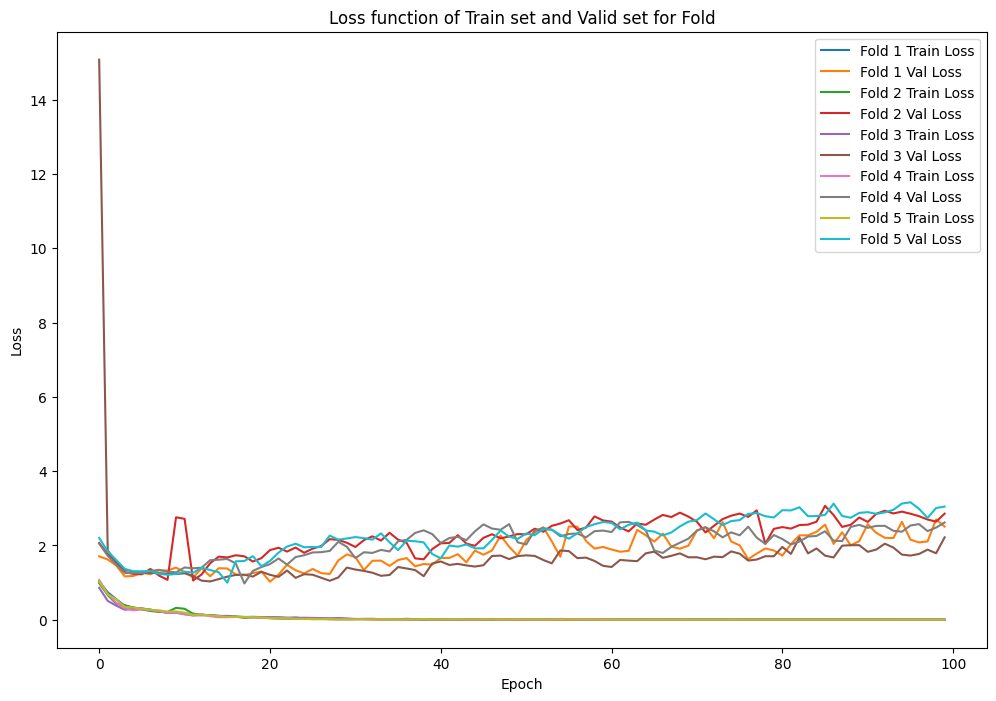

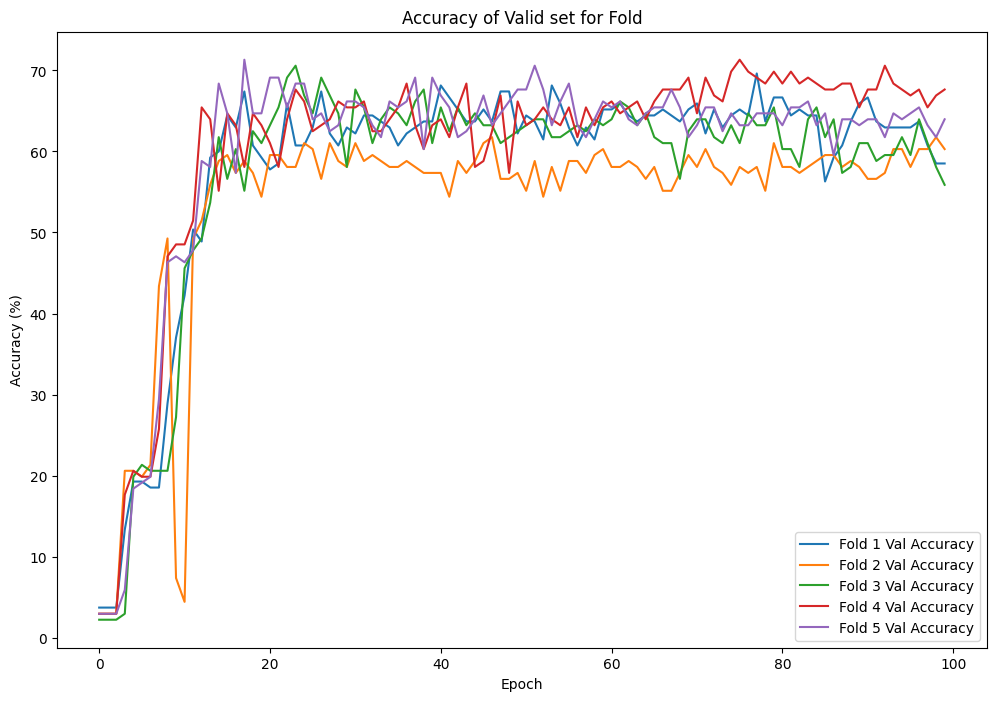

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for result in fold_results:
    plt.plot(result['train_losses'], label=f'Fold {result["fold"]} Train Loss')
    plt.plot(result['val_losses'], label=f'Fold {result["fold"]} Val Loss')
plt.title('Loss function of Train set and Valid set for Fold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
for result in fold_results:
    plt.plot(result['val_accuracies'], label=f'Fold {result["fold"]} Val Accuracy')
plt.title('Accuracy of Valid set for Fold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

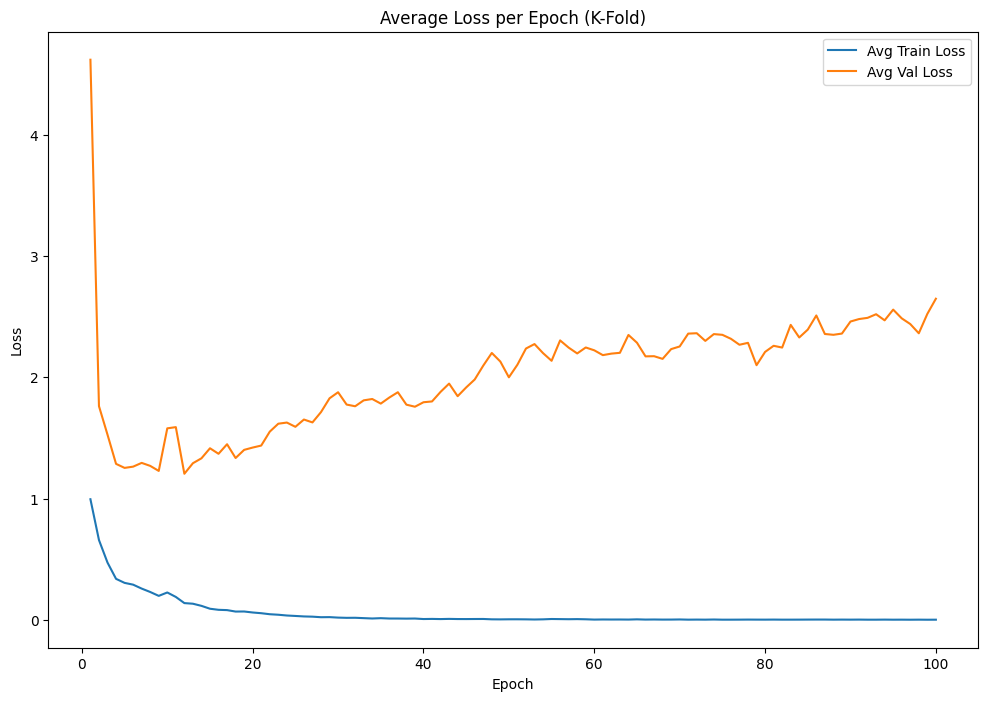

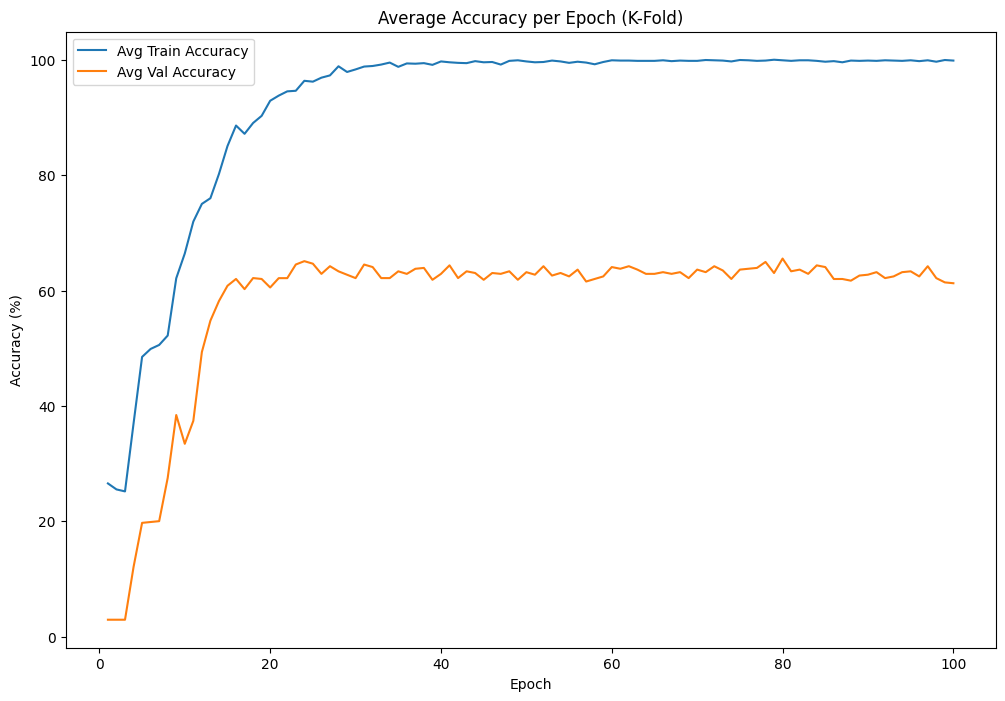

In [ ]:
# Number of epochs
num_epochs = len(fold_results[0]['train_losses'])

# Compute per-epoch averages
avg_train_losses    = [np.mean([fold['train_losses'][e]    for fold in fold_results]) for e in range(num_epochs)]
avg_val_losses      = [np.mean([fold['val_losses'][e]      for fold in fold_results]) for e in range(num_epochs)]
avg_train_accuracies = [np.mean([fold['train_accuracies'][e] for fold in fold_results]) for e in range(num_epochs)]
avg_val_accuracies   = [np.mean([fold['val_accuracies'][e]   for fold in fold_results]) for e in range(num_epochs)]

np.save('avg_train_losses_resnet50_nocrop_cw.npy', avg_train_losses)
np.save('avg_val_losses_resnet50_nocrop_cw.npy', avg_val_losses)
np.save('avg_train_accuracies_resnet50_nocrop_cw.npy', avg_train_accuracies)
np.save('avg_val_accuracies_resnet50_nocrop_cw.npy', avg_val_accuracies)

epochs = np.arange(1, num_epochs+1)

# Plot Loss
plt.figure(figsize=(12, 8))
plt.plot(epochs, avg_train_losses,    label='Avg Train Loss')
plt.plot(epochs, avg_val_losses,      label='Avg Val Loss')
plt.title('Average Loss per Epoch (K-Fold)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(12, 8))
plt.plot(epochs, avg_train_accuracies, label='Avg Train Accuracy')
plt.plot(epochs, avg_val_accuracies,   label='Avg Val Accuracy')
plt.title('Average Accuracy per Epoch (K-Fold)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()